In [1]:
import pandas as pd
import seaborn as sns
import datetime
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

import logging
logging.basicConfig(level=logging.WARN)

/home/sreeaurovindh/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/sreeaurovindh/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import os
from natsort import natsorted

path ='../Time_data_08_25_2017_12_36PM/' # use your path
allFiles = [path+file for file in natsorted(os.listdir(path)) if not file.startswith('TBLT_')]
allFiles
print("Total Files",len(allFiles))

Total Files 18


In [10]:
data = pd.DataFrame()
list_ = []
file_id_list = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=None)
    dt = df.loc[:,3:4].drop_duplicates()
    dt.columns = ["label","id"]
    dt['act_id'] = dt["id"].astype(int)
    dt['act_id'] = dt['act_id'] - min(dt['id']) + 1
    dt['file'] = file_.split("/")[2]
    file_id_list.append(dt)
    list_.append(df)
data = pd.concat(list_)
file_list = pd.concat(file_id_list)
file_list.columns = ['label','id','actual_id','Filename']

In [13]:
data.columns = ['time','P1','P2','label','id']

In [14]:
# Convert to Milliseconds
data['time'] = data['time'] * 1e+3


In [15]:
# Take one sample for every 1000 samples
data = data.iloc[::1000, :]

In [16]:
# Sort data frame by id and time
data = data.sort_values(['id', 'time'], ascending=[True, True])

In [17]:
id_values = data.id.unique()

In [18]:
data.head()

time   P1   P2 label  id
0       0.0  1.0  1.0     P   1
1000  125.0  1.0  1.0     P   1
2000  250.0  1.0  1.0     P   1
3000  375.0  1.0  1.0     P   1
4000  500.0  1.0  1.0     P   1

In [22]:
file_list.head()

label  id  actual_id              Filename
0           P   1          1  11-14-2014-320-G.csv
313784      C   2          2  11-14-2014-320-G.csv
3067441     C   3          3  11-14-2014-320-G.csv
5025970    C    4          4  11-14-2014-320-G.csv
7463963     A   5          5  11-14-2014-320-G.csv

In [23]:
file_list.loc[file_list['id']==1,["actual_id","Filename"]]

actual_id              Filename
0          1  11-14-2014-320-G.csv

In [ ]:
data

/home/sreeaurovindh/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


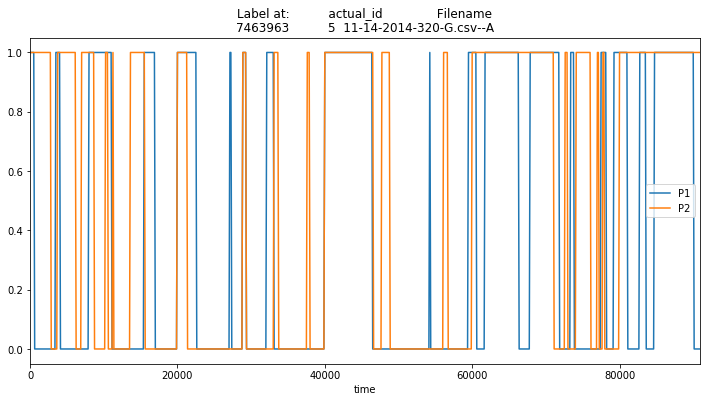

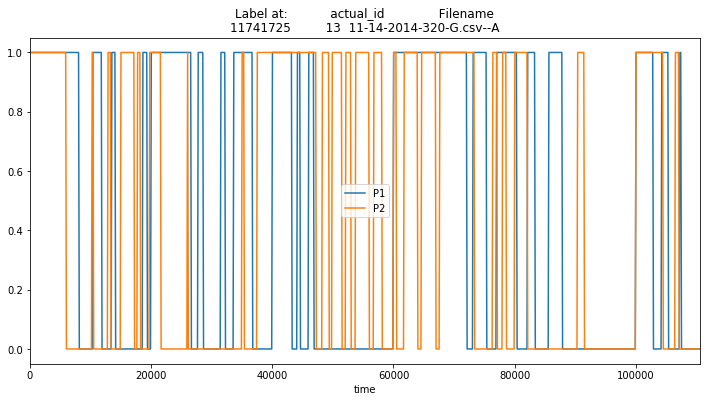

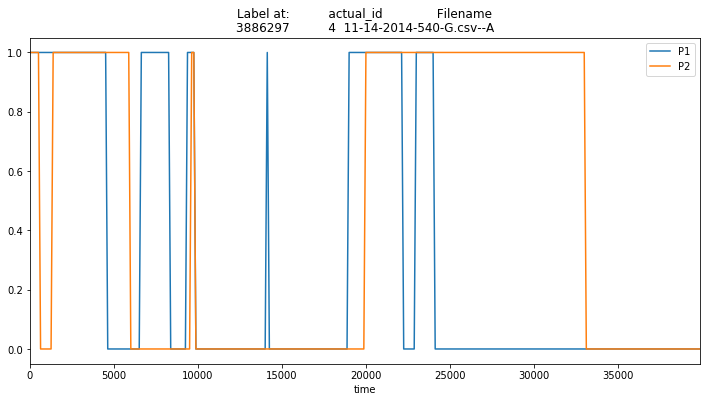

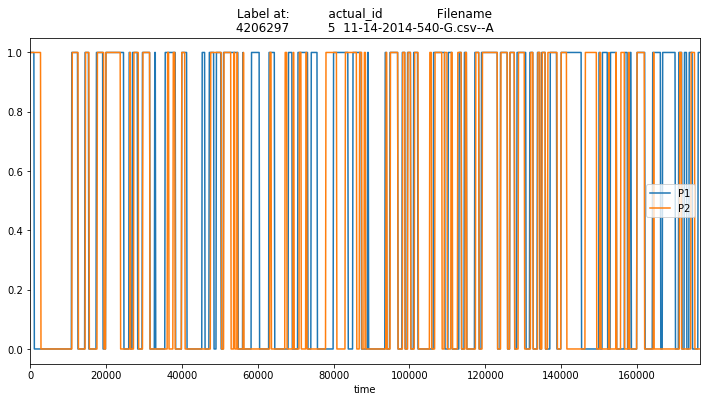

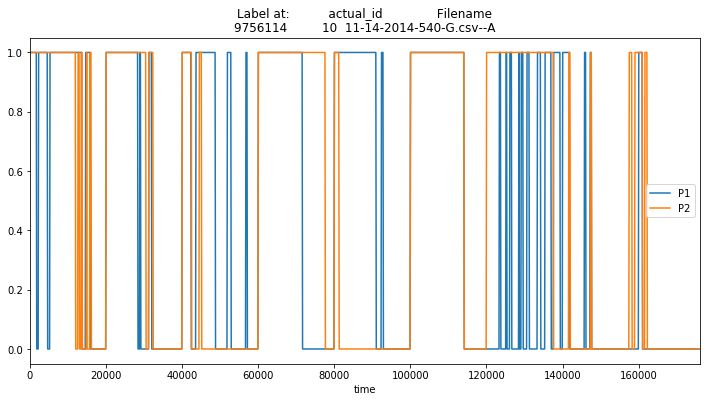

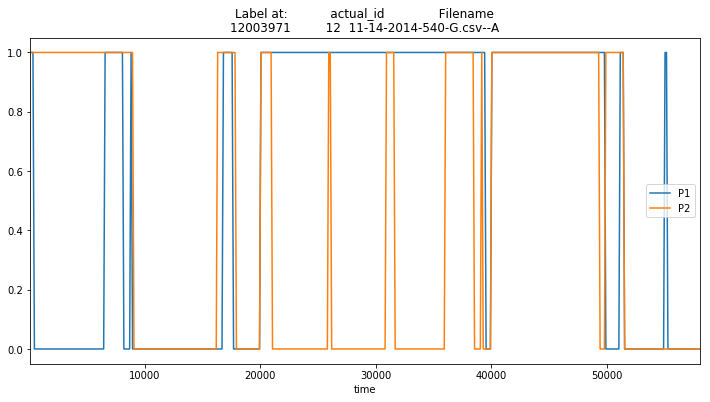

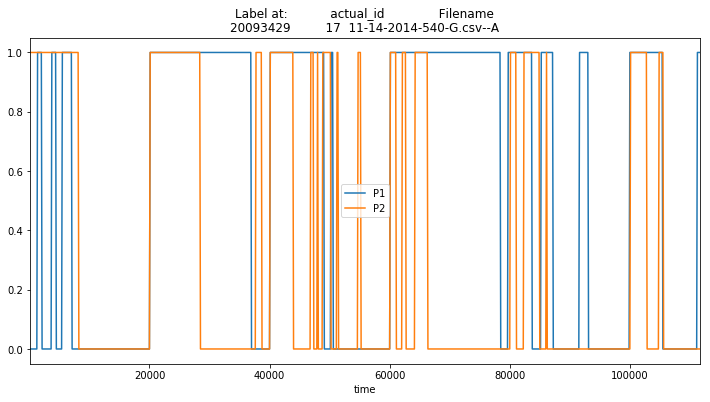

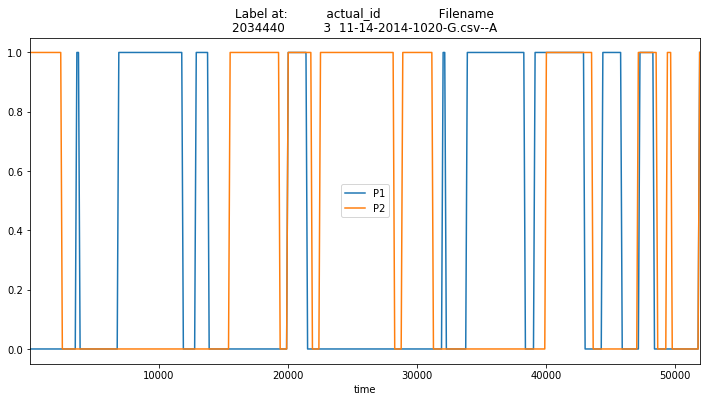

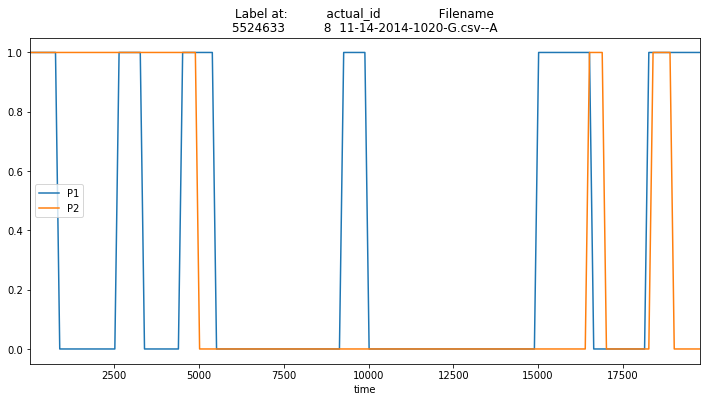

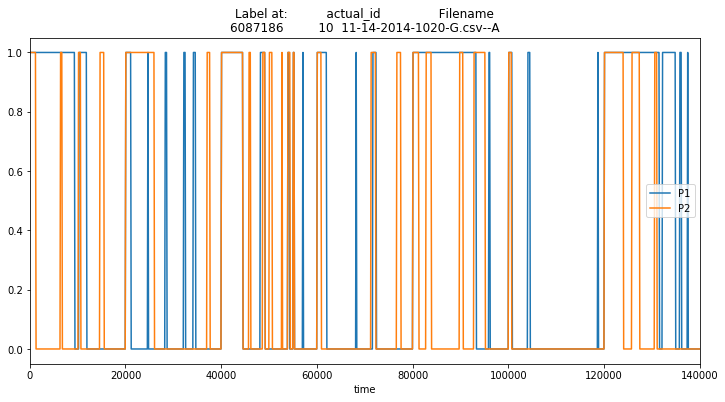

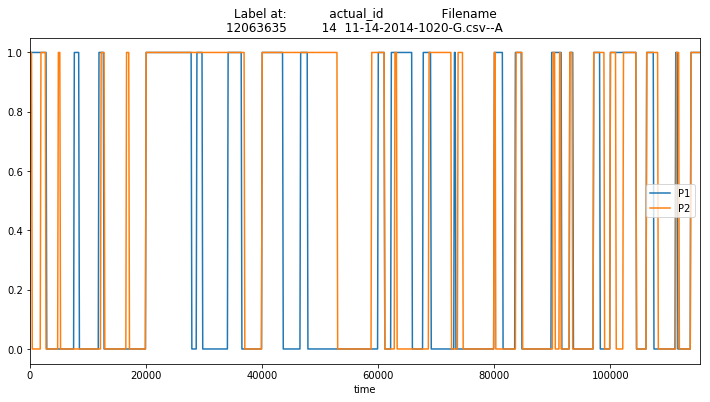

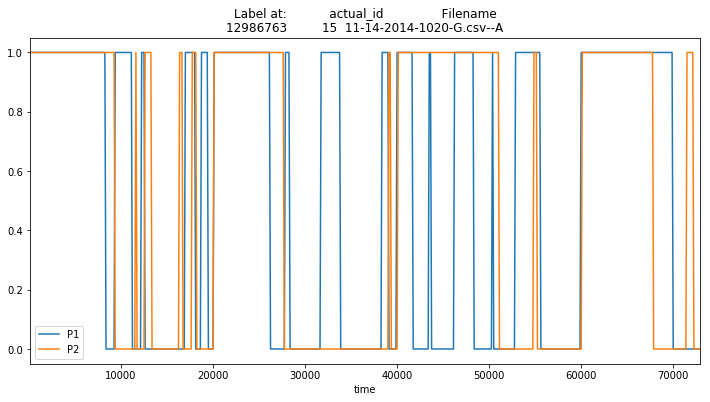

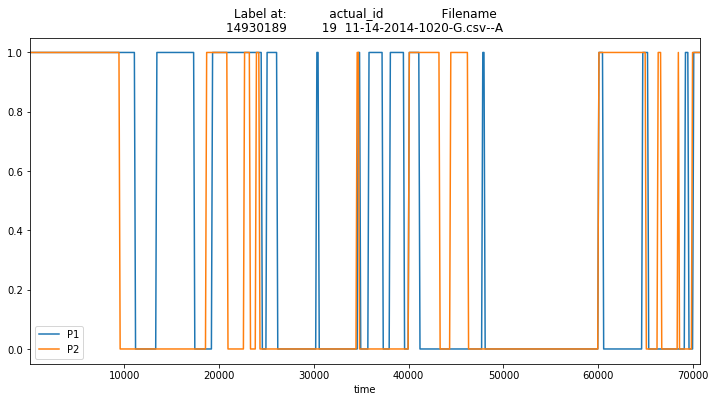

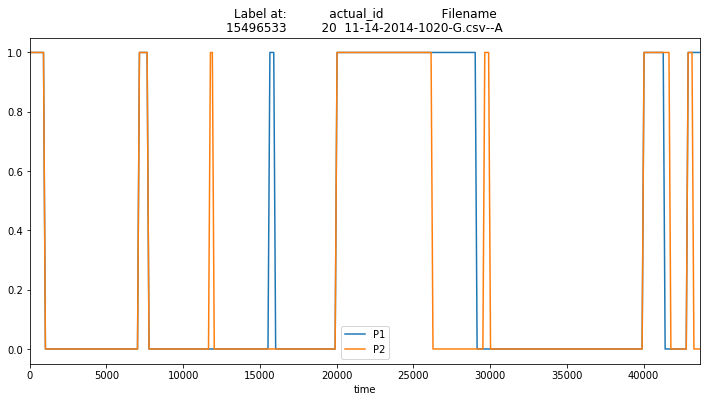

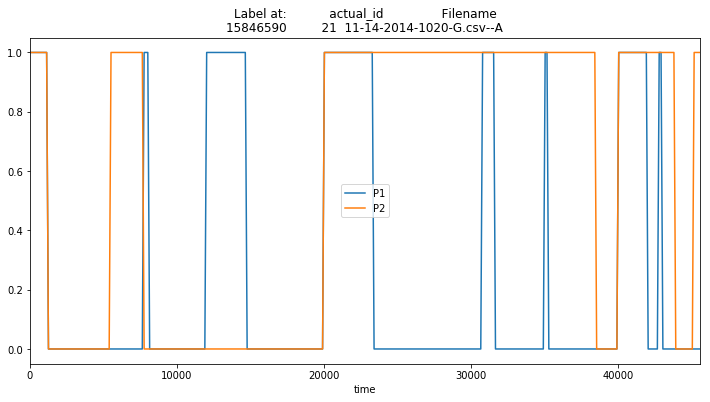

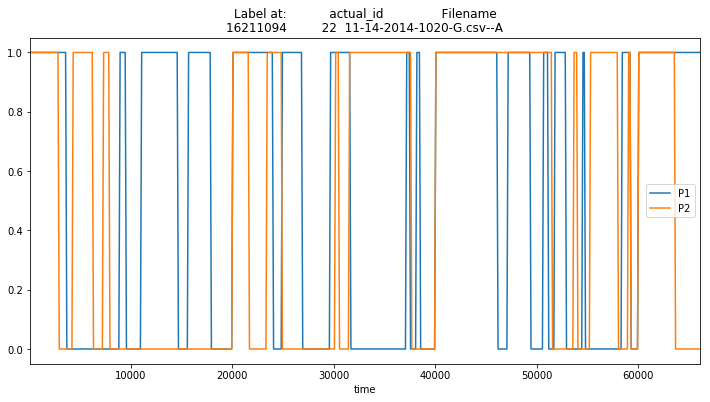

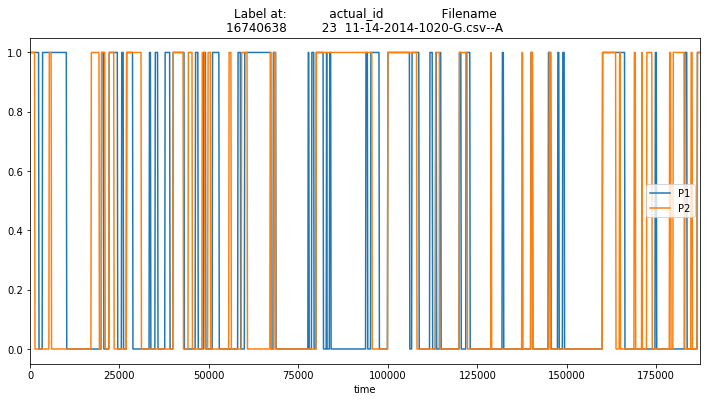

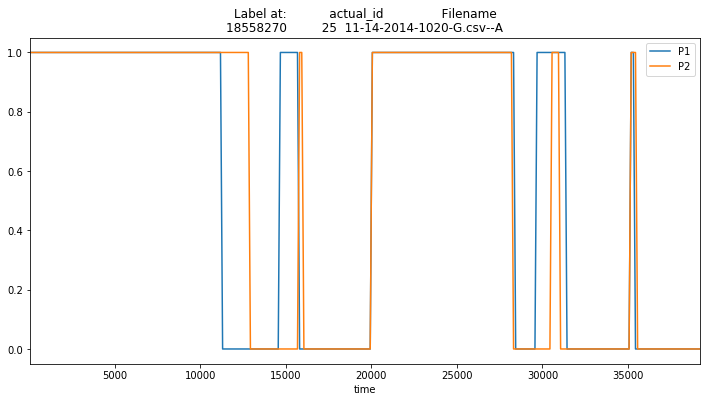

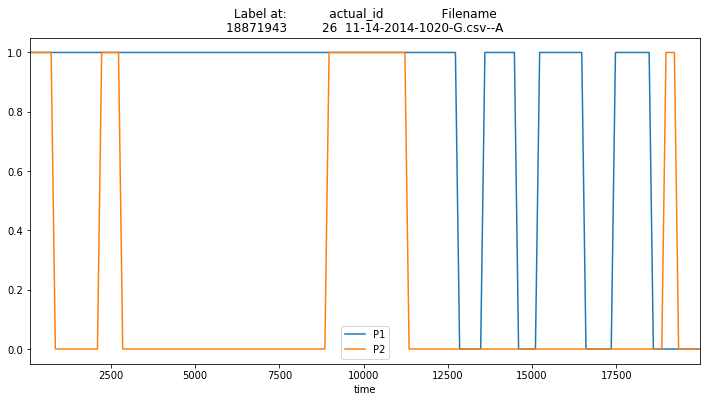

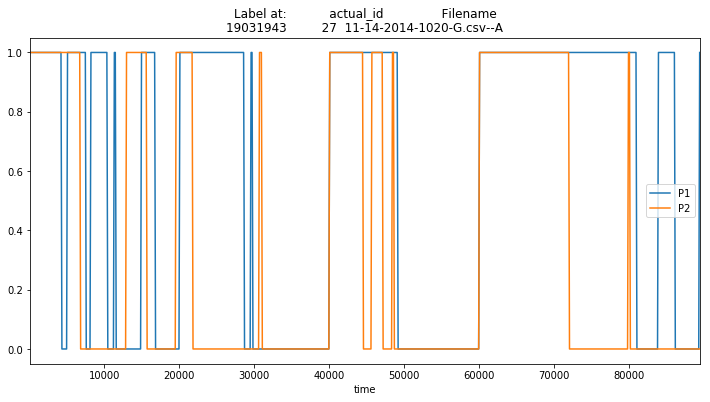

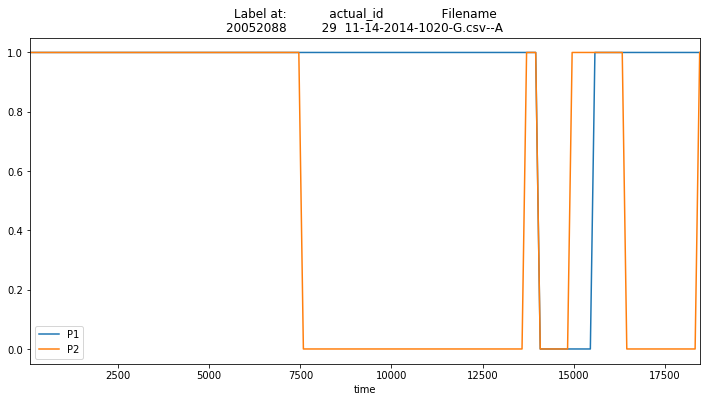

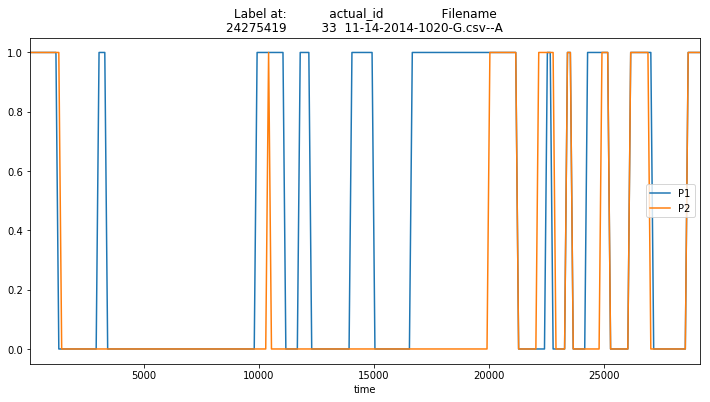

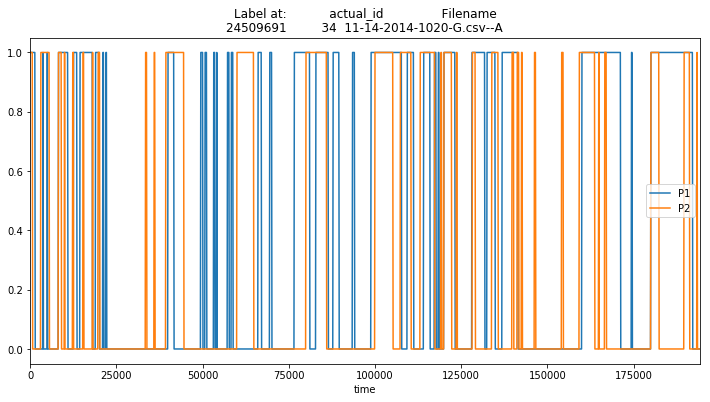

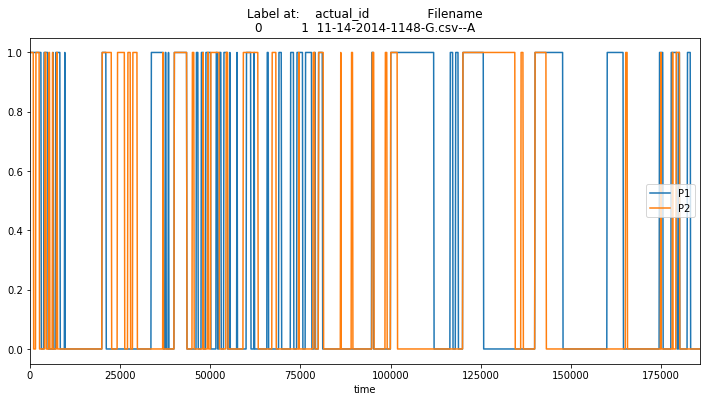

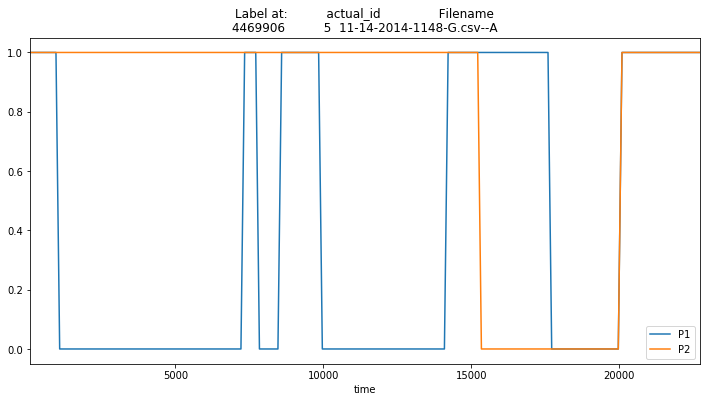

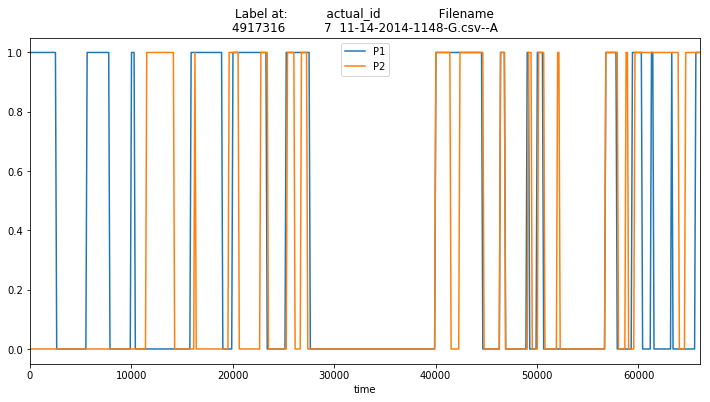

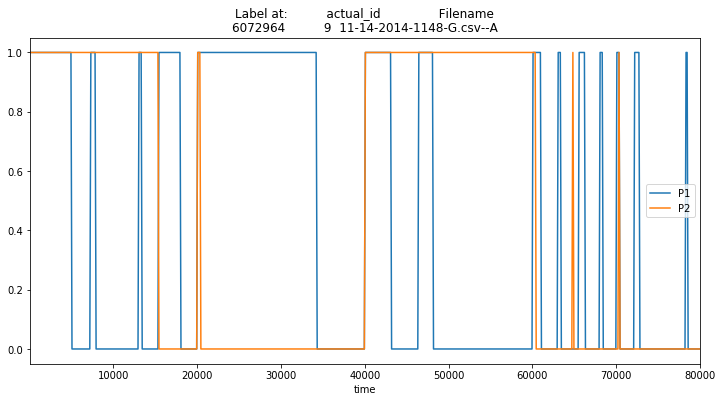

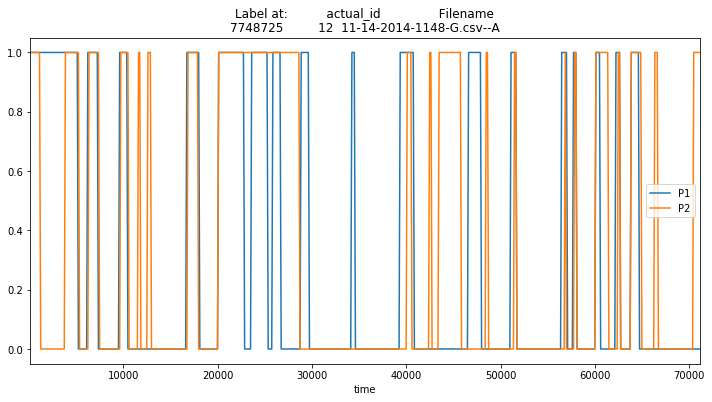

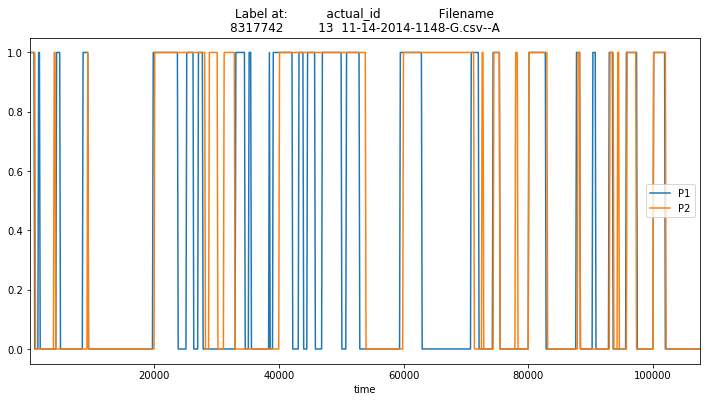

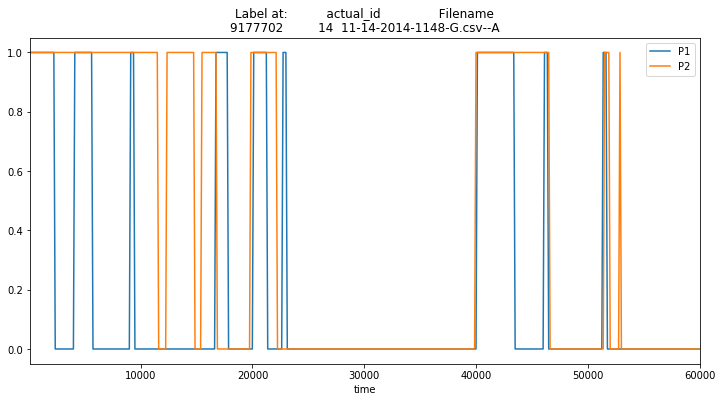

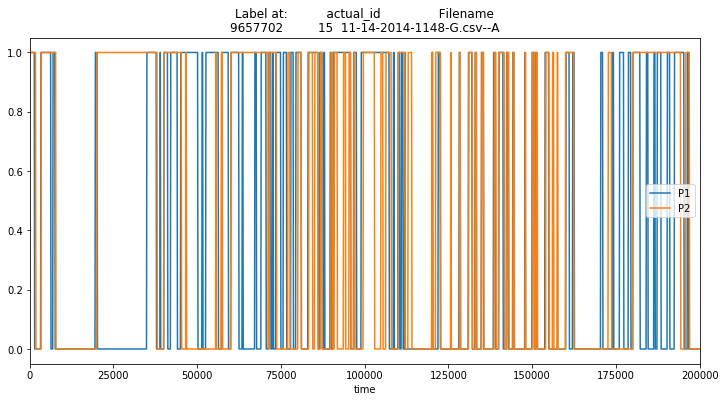

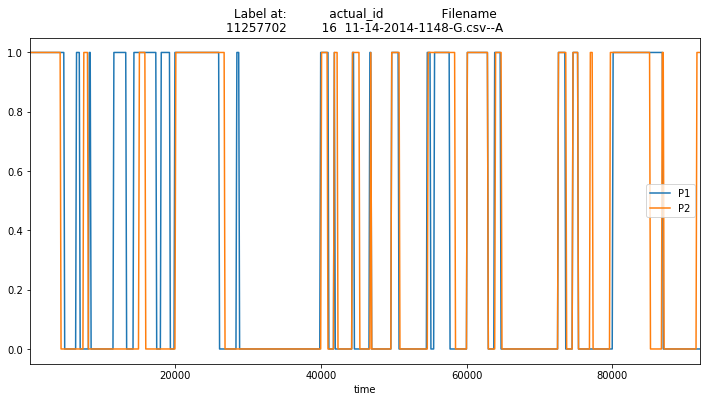

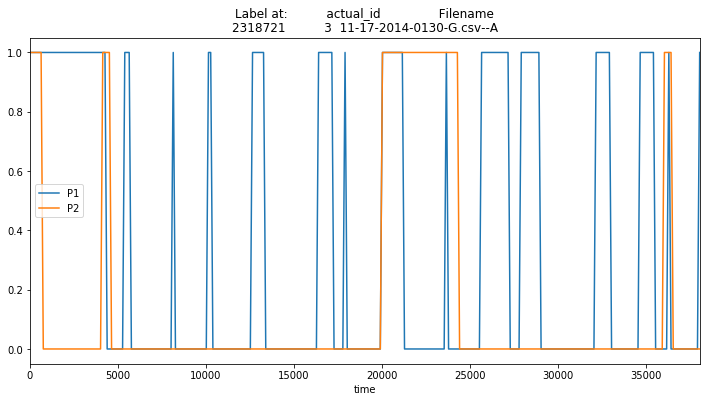

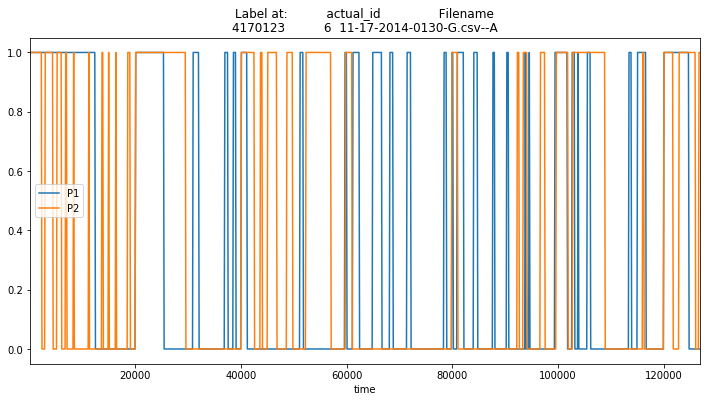

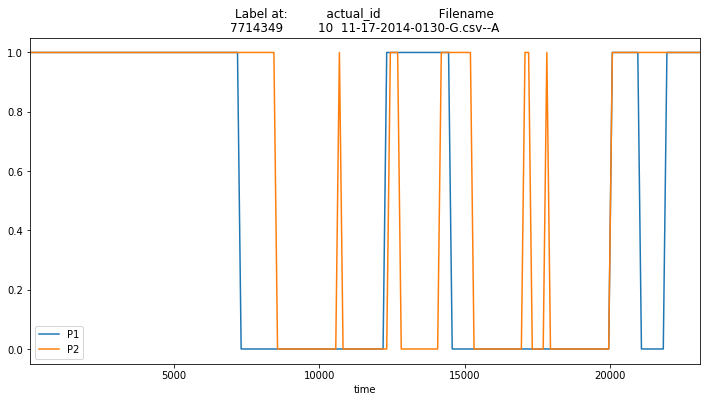

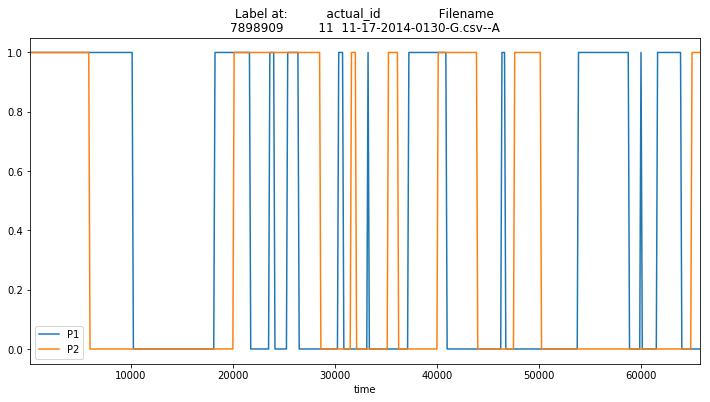

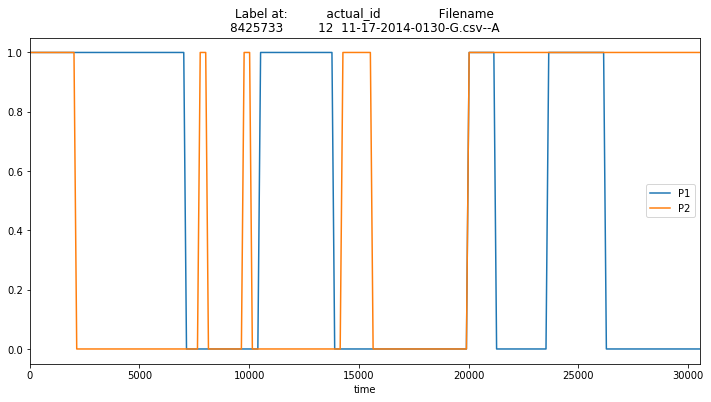

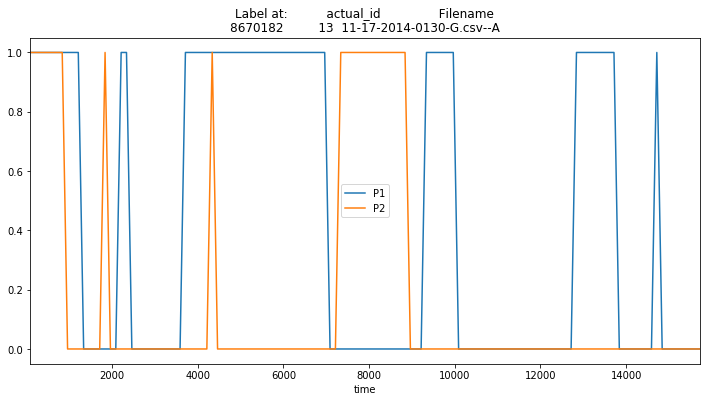

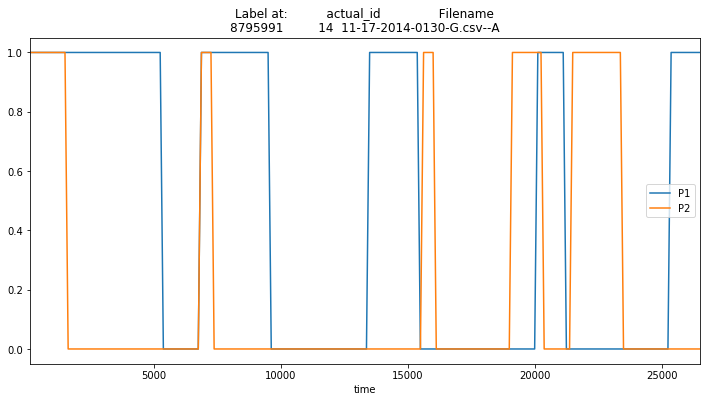

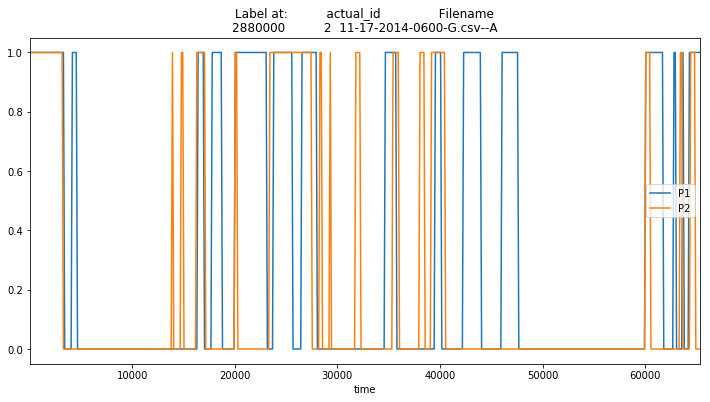

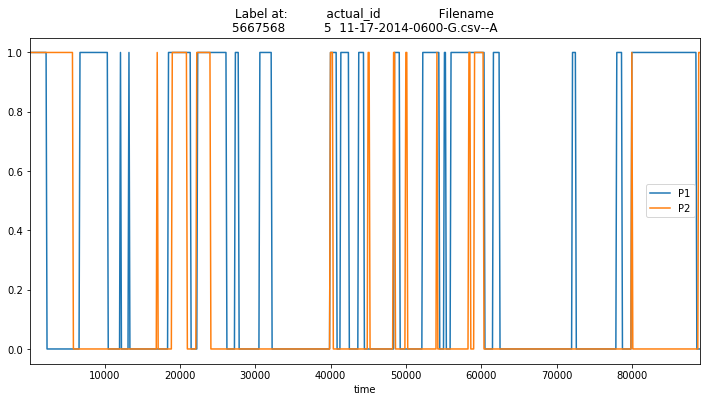

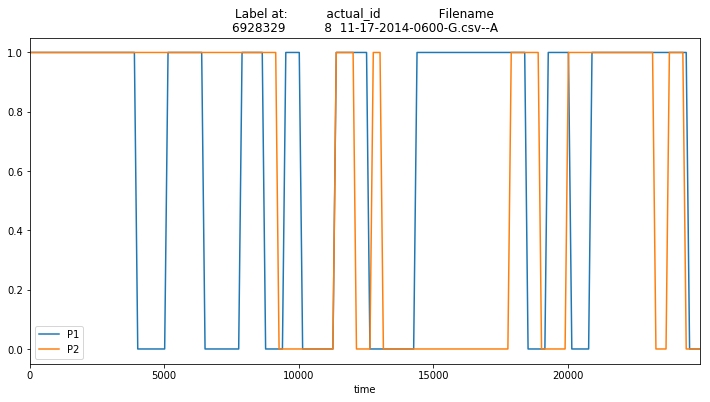

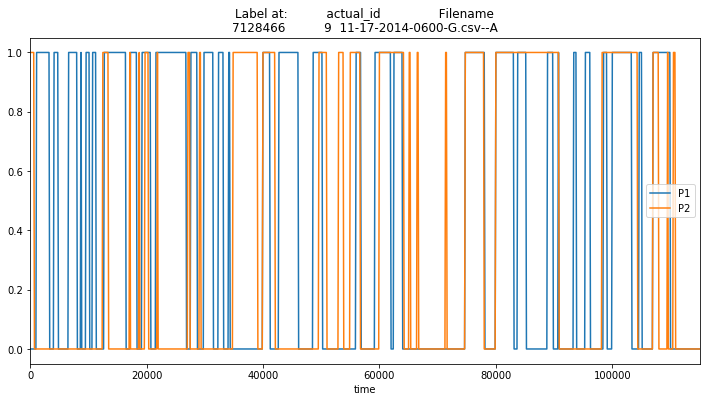

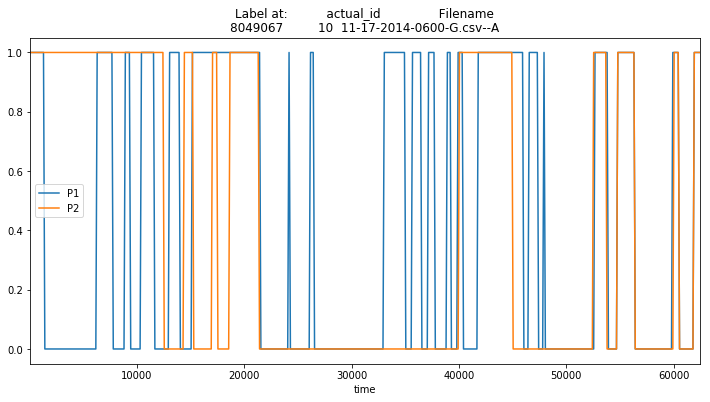

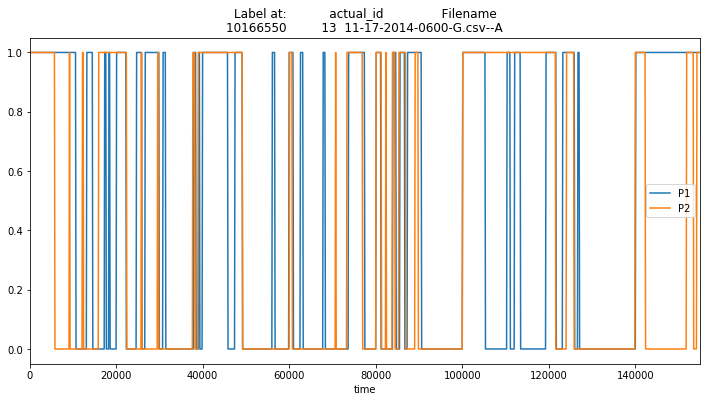

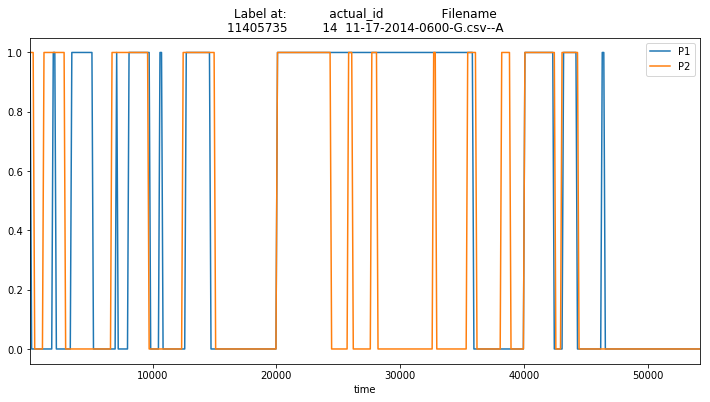

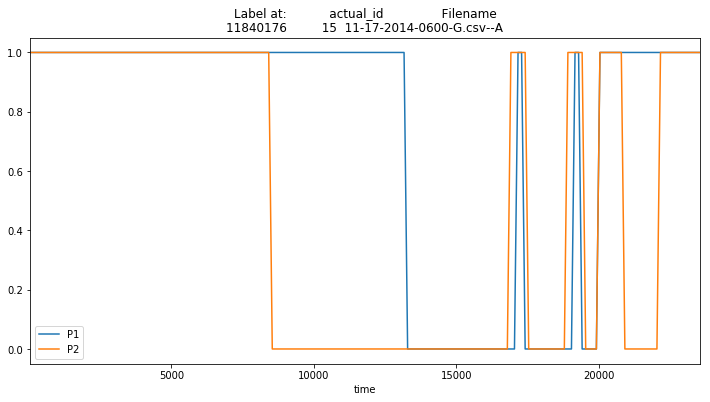

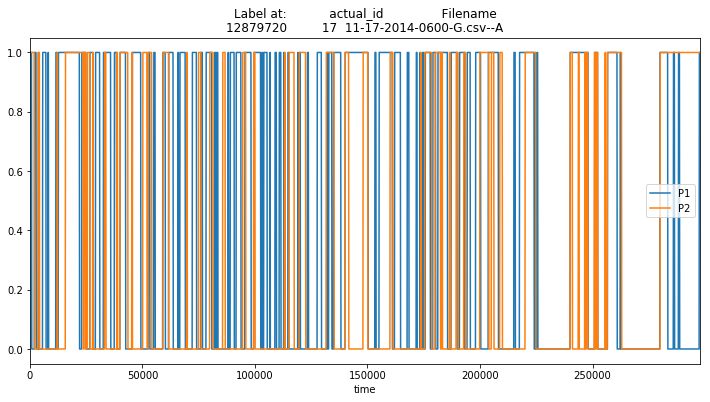

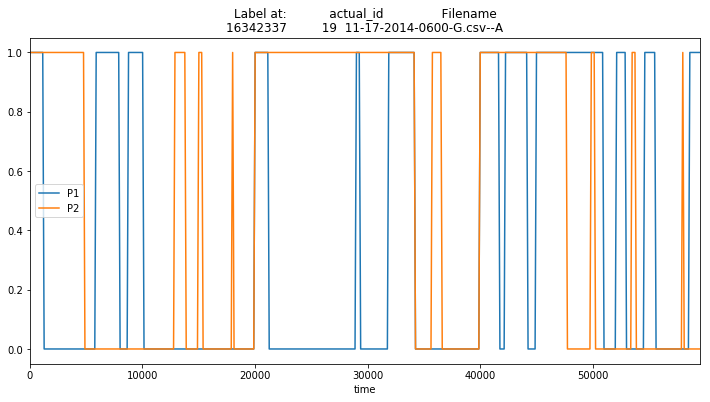

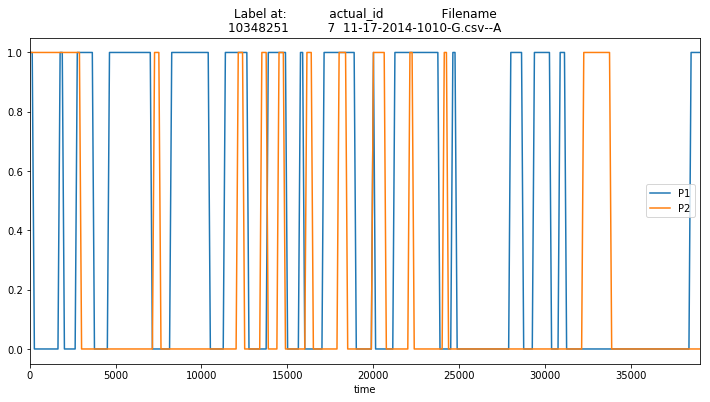

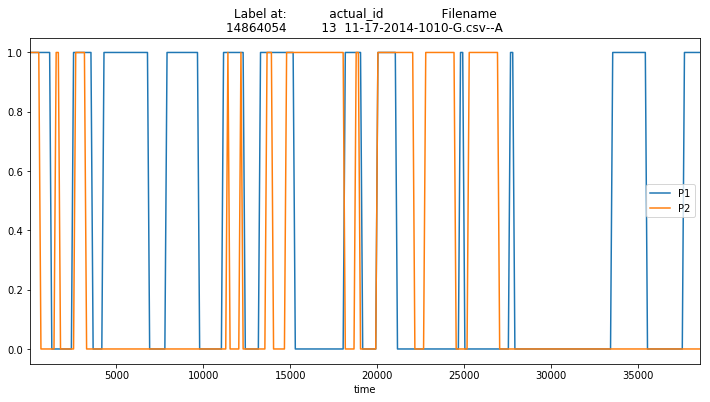

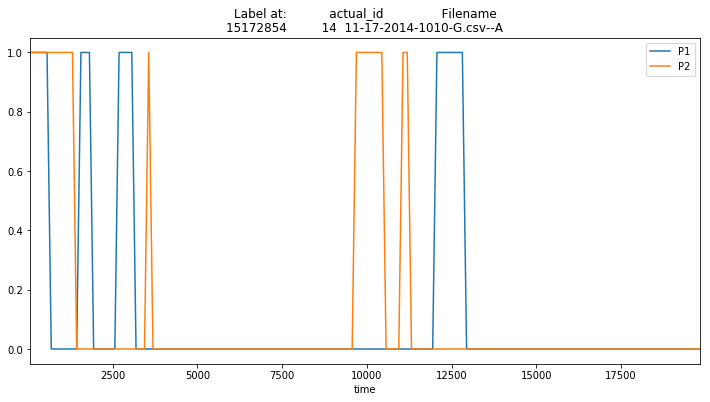

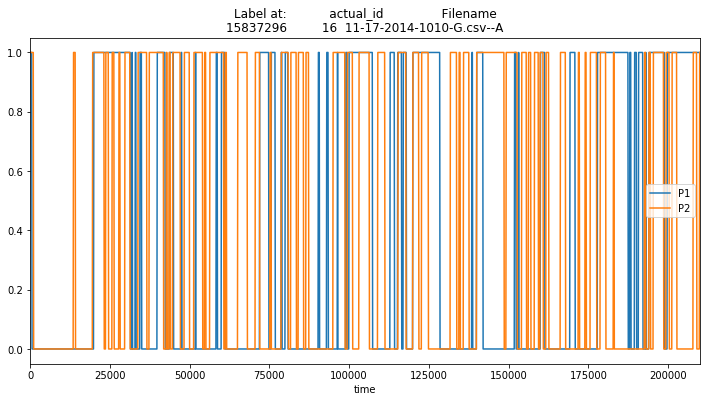

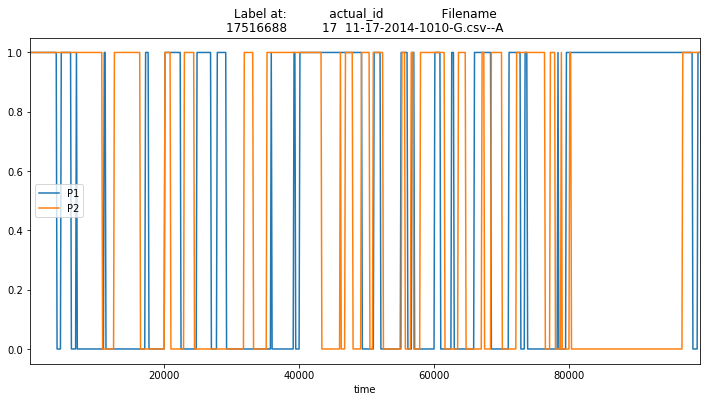

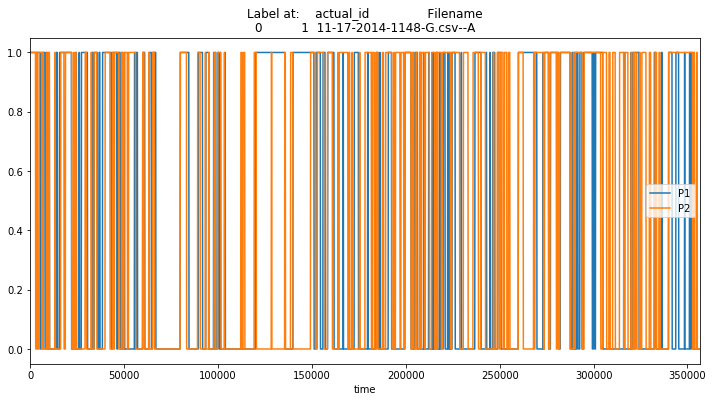

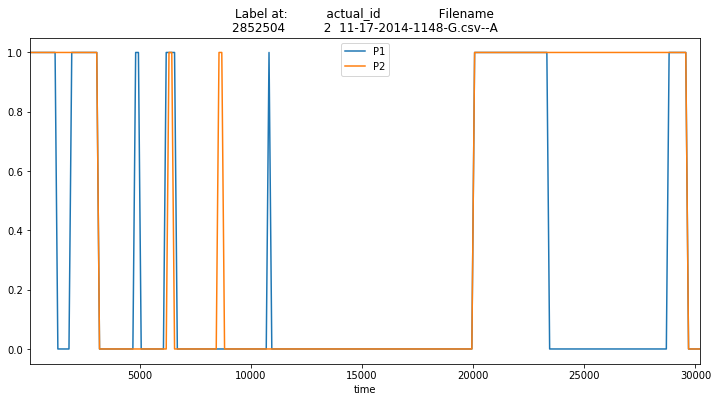

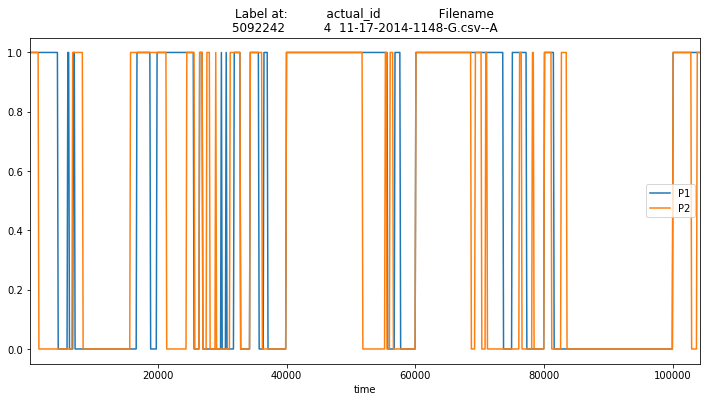

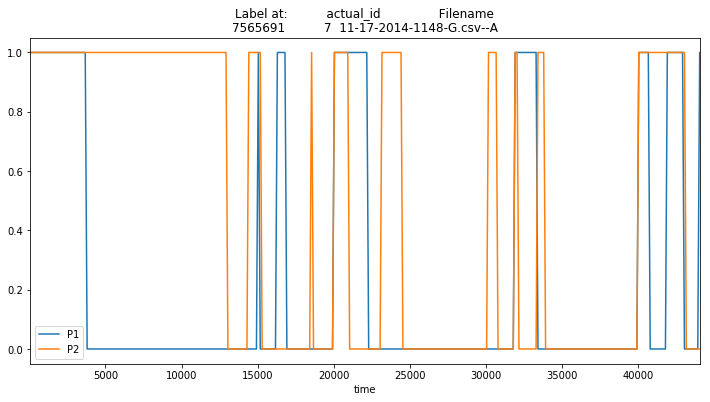

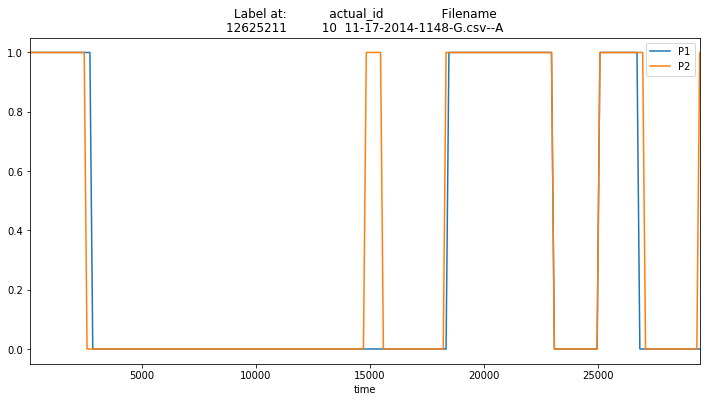

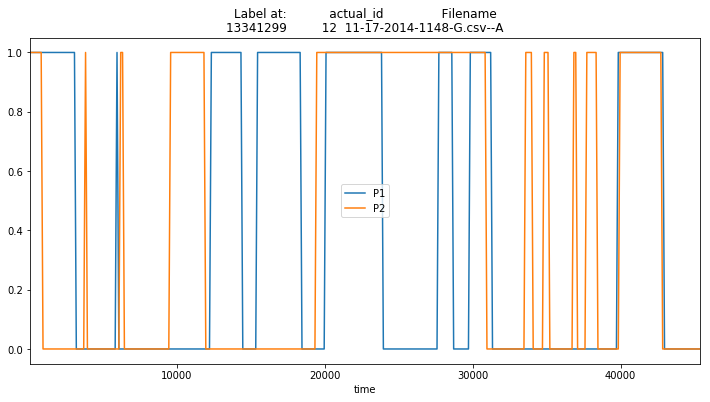

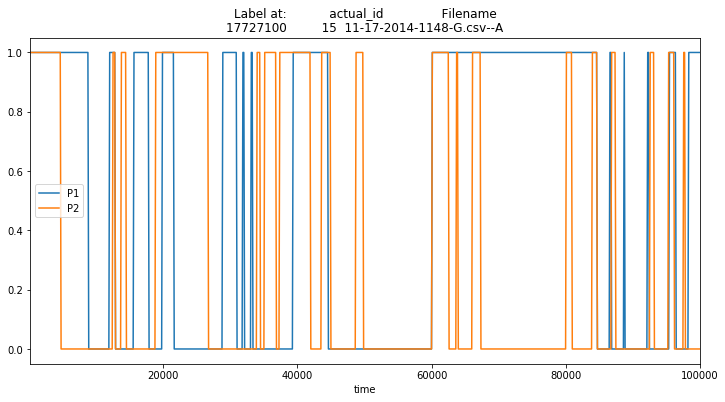

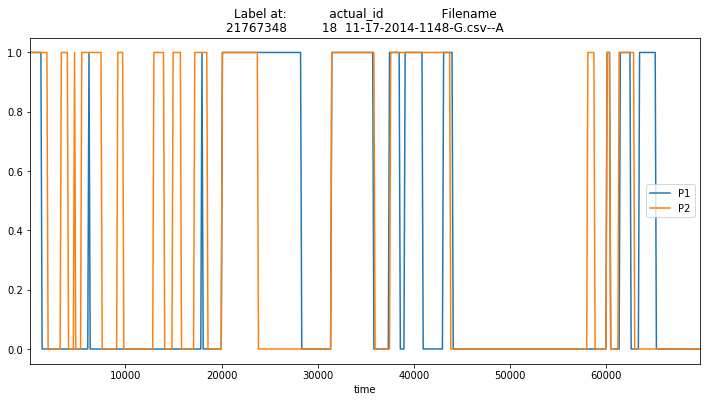

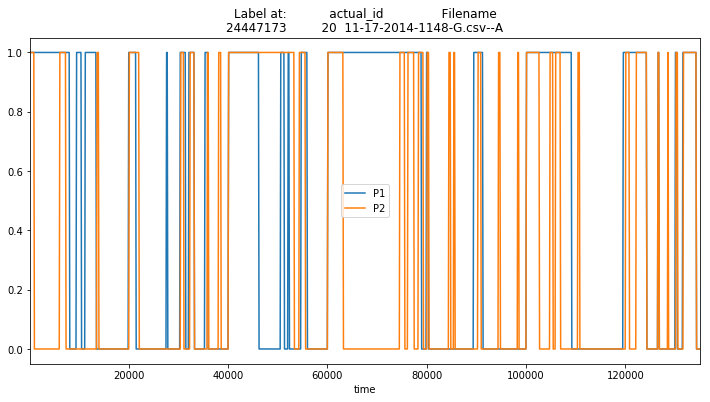

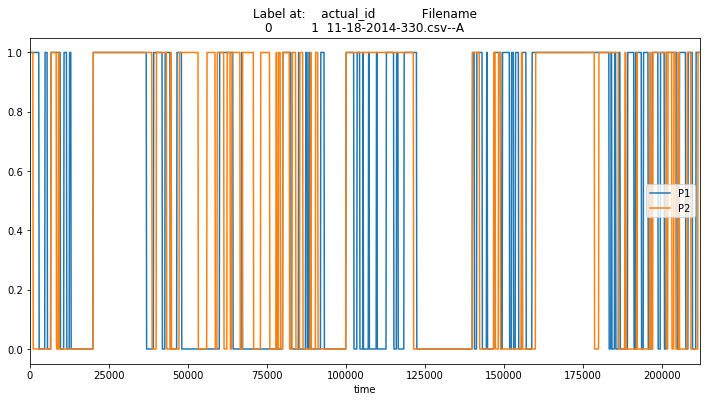

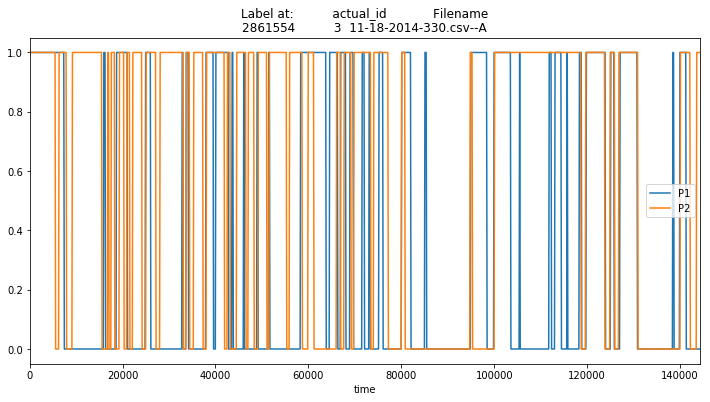

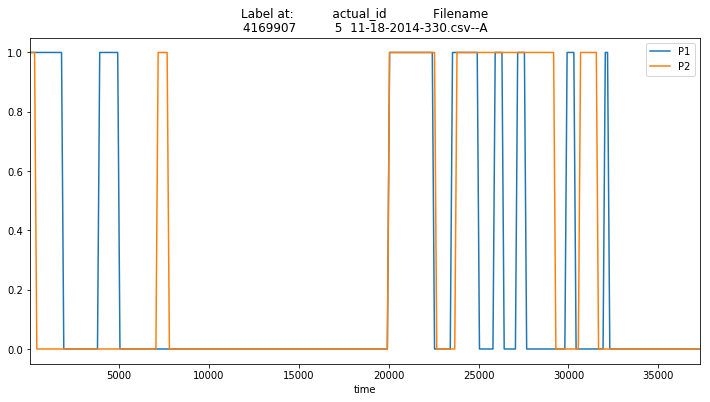

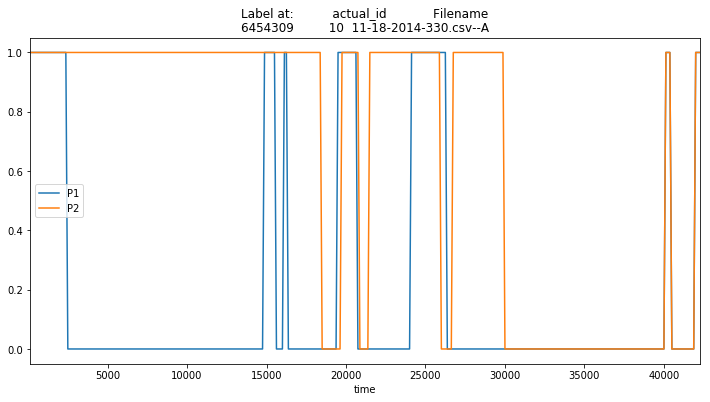

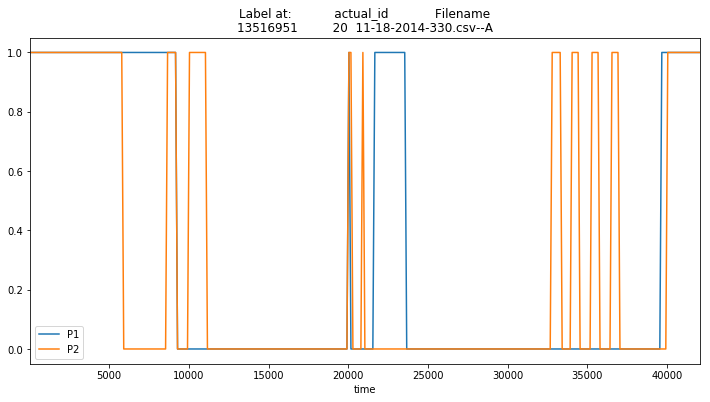

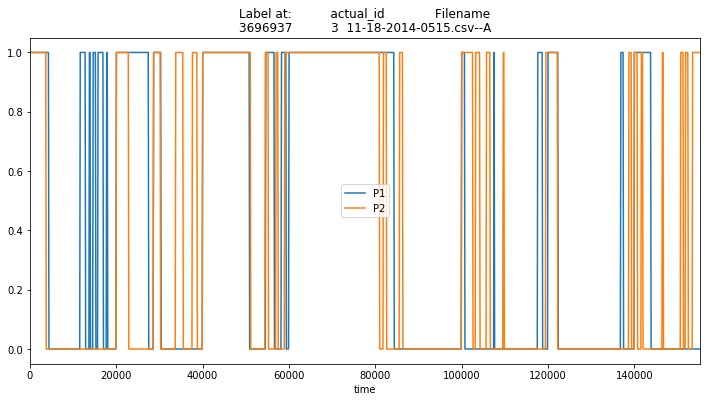

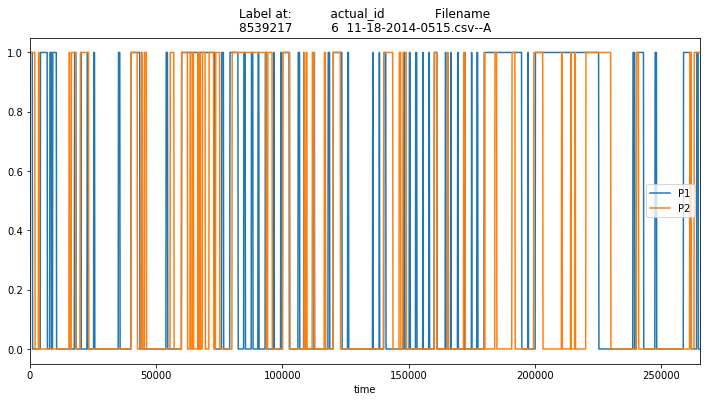

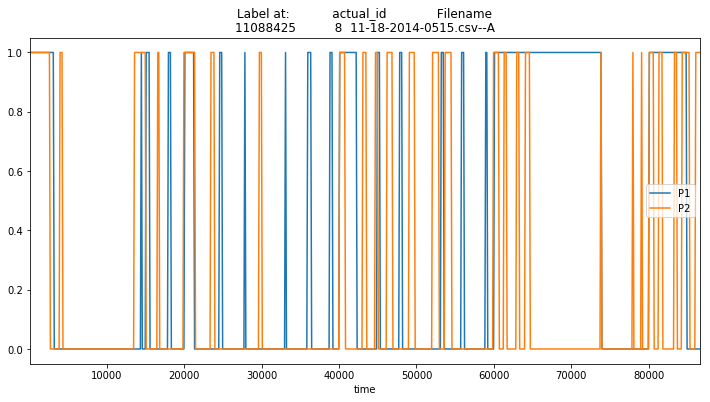

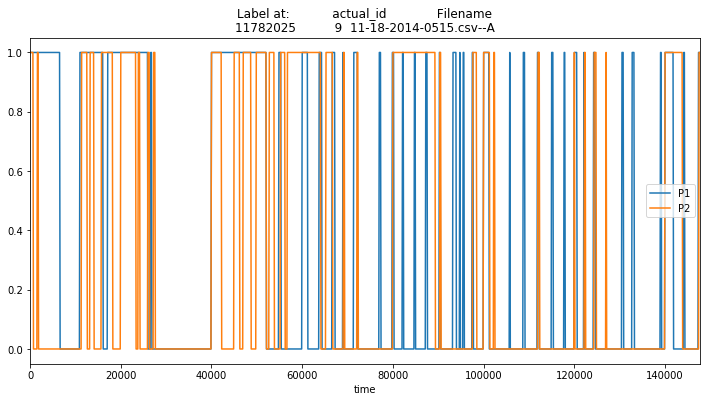

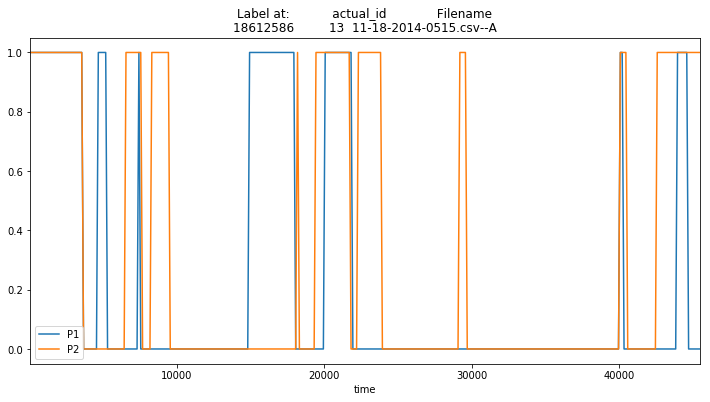

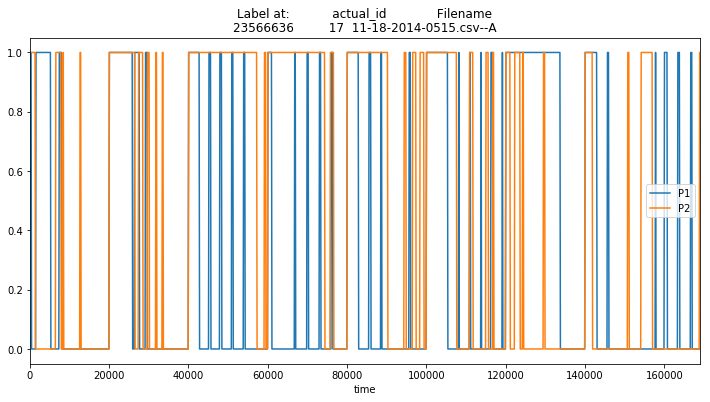

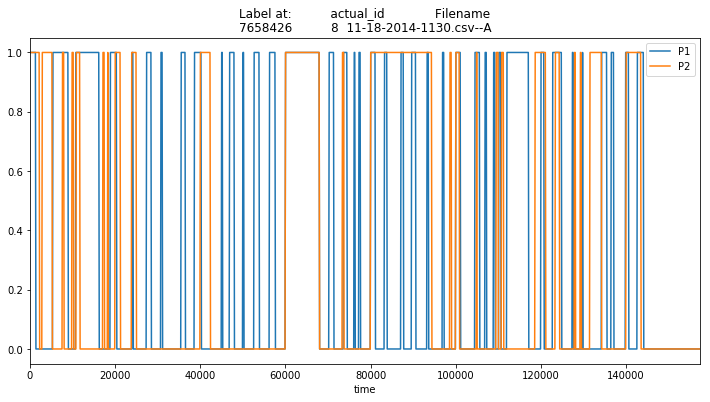

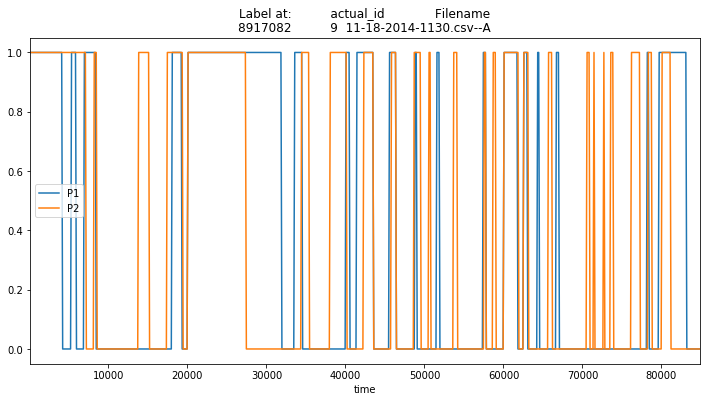

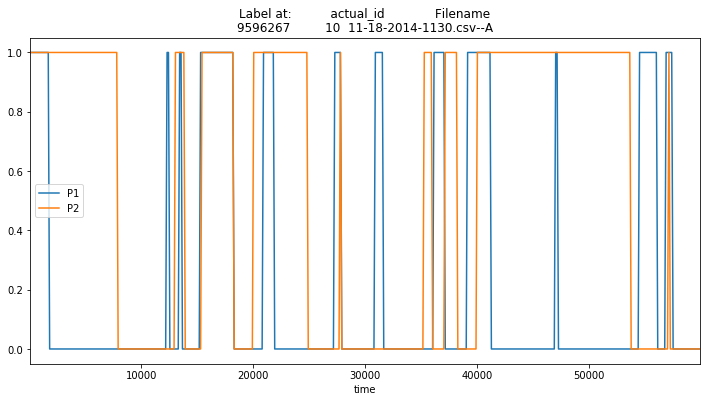

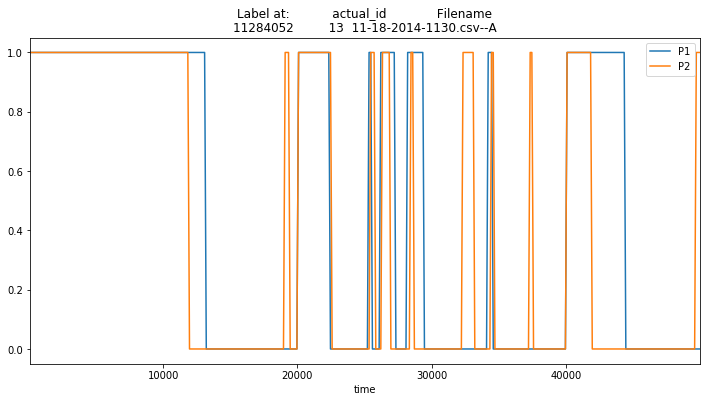

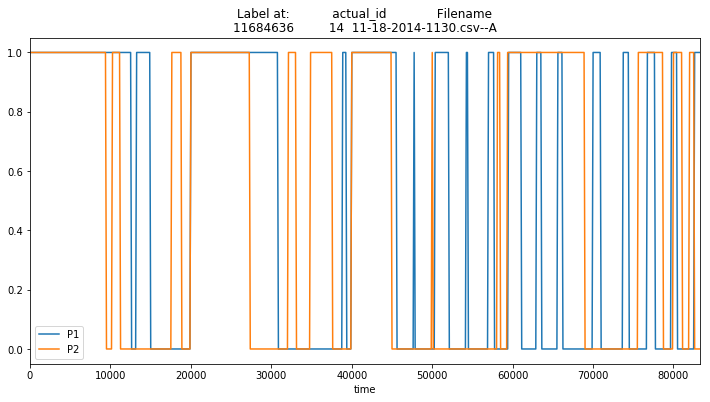

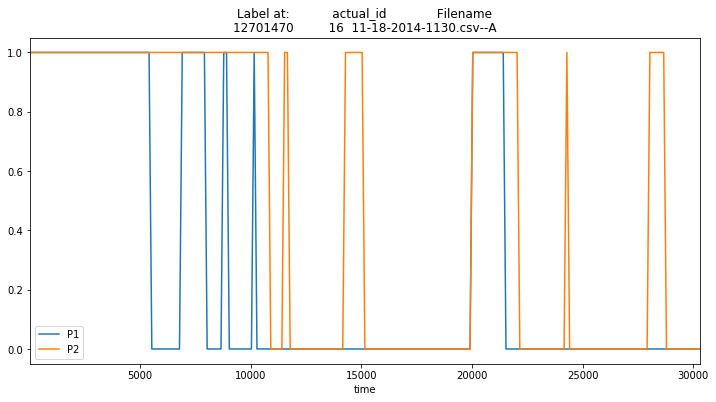

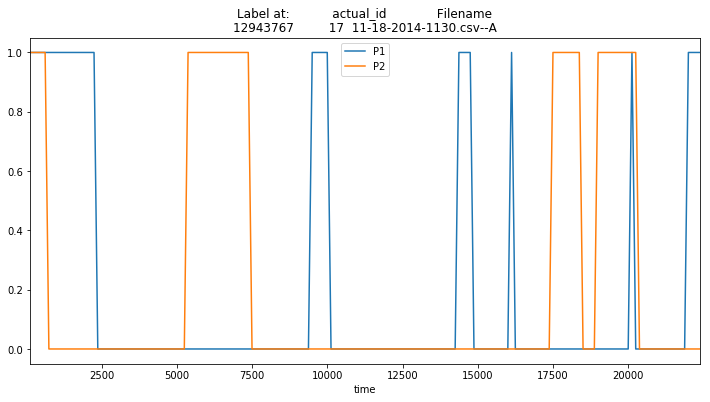

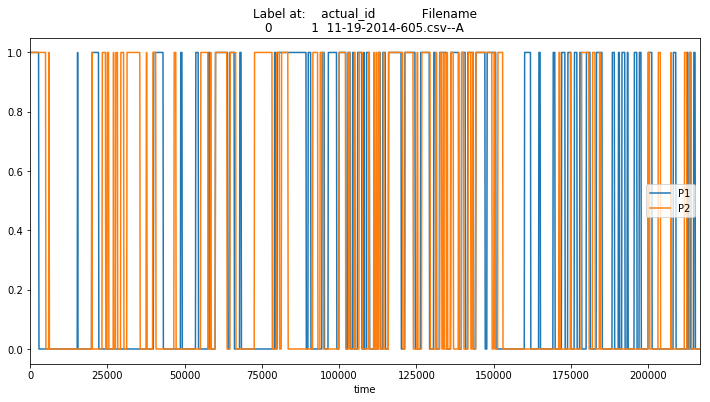

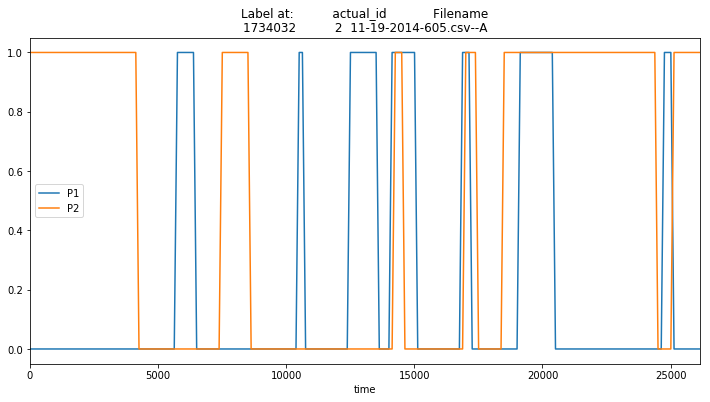

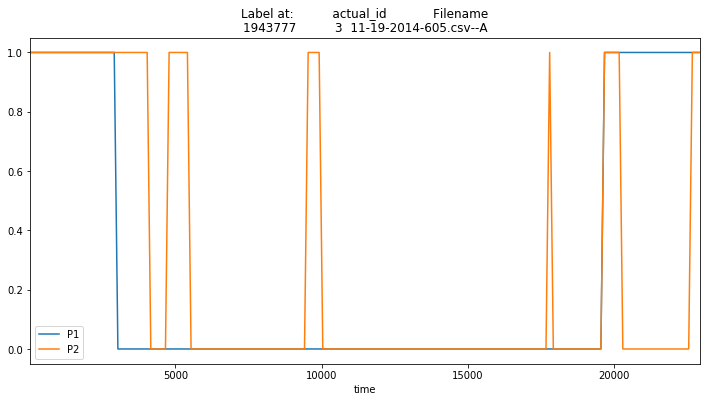

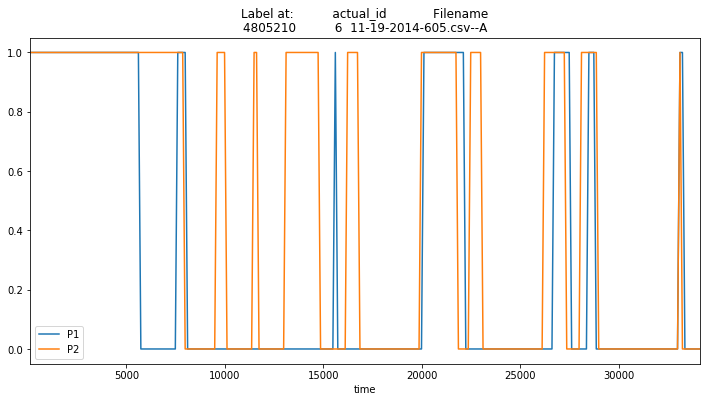

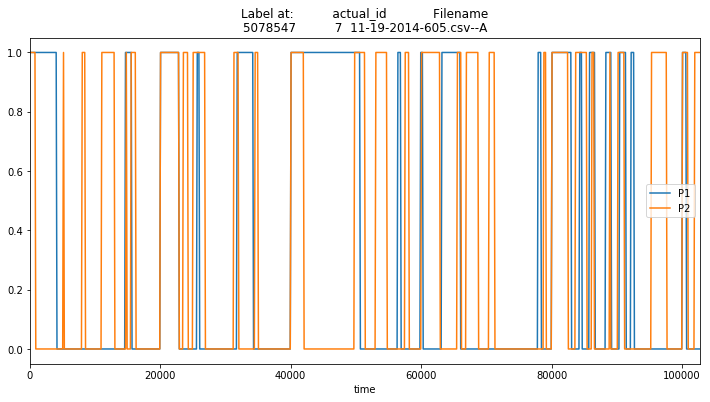

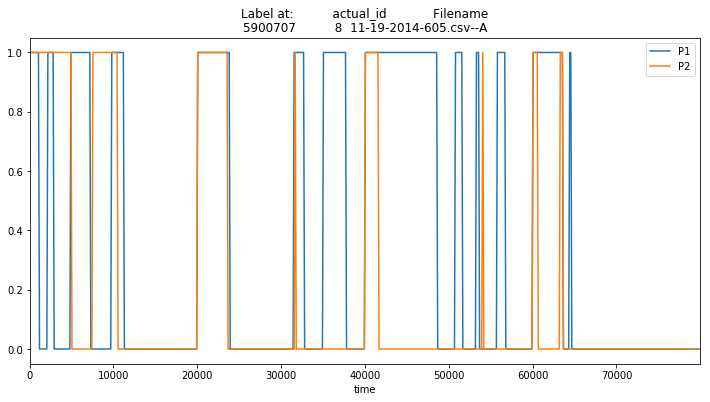

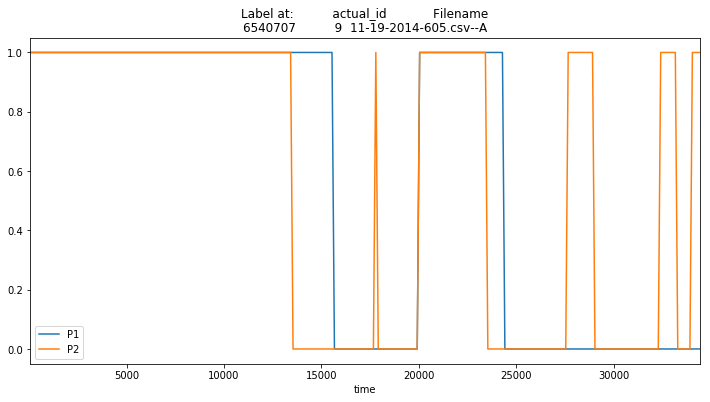

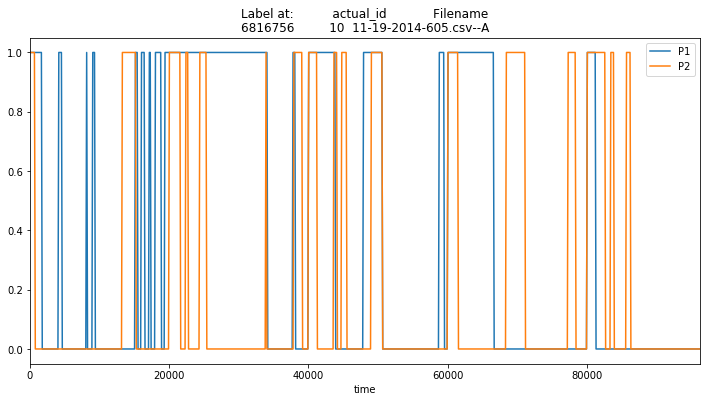

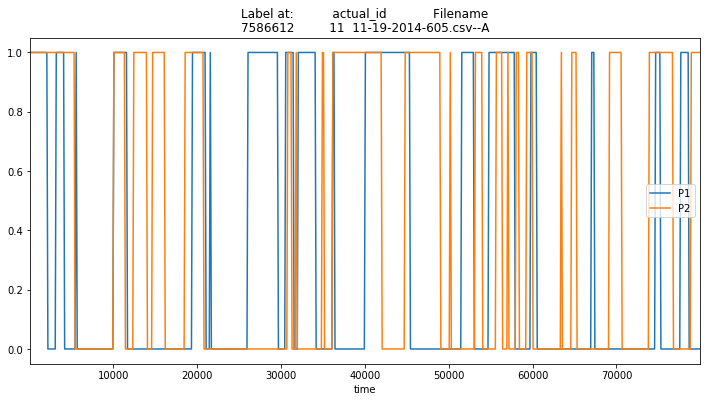

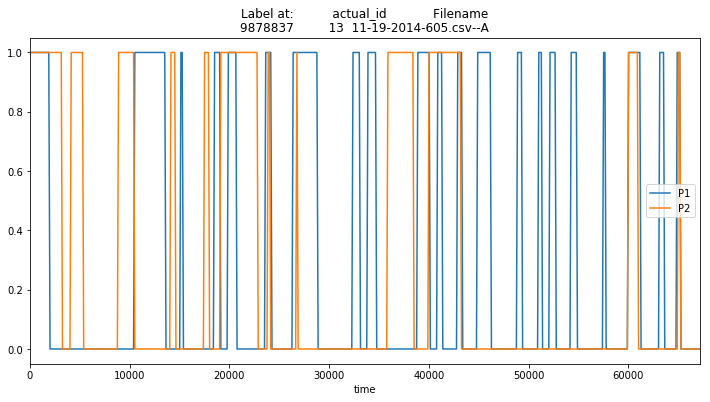

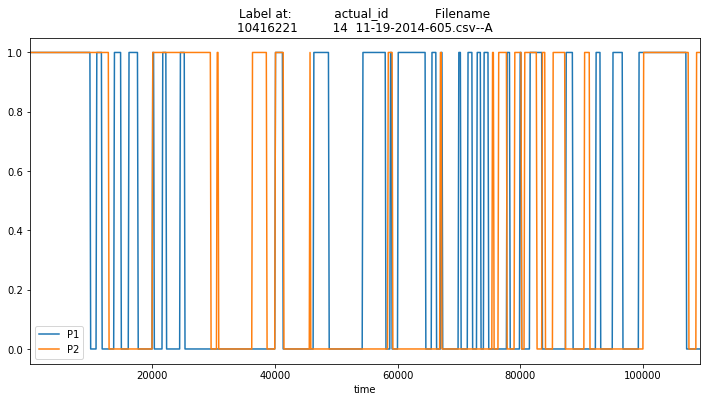

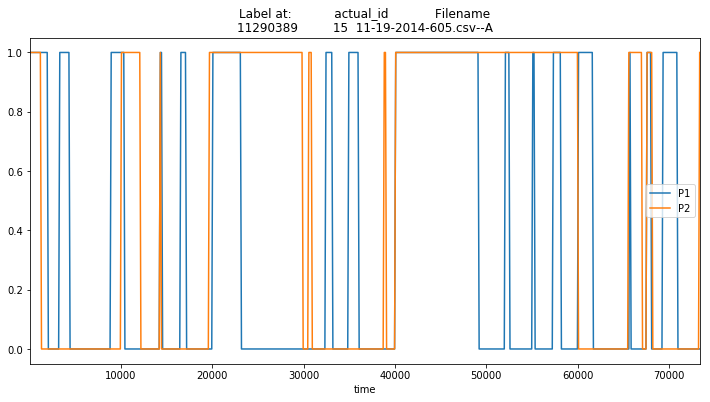

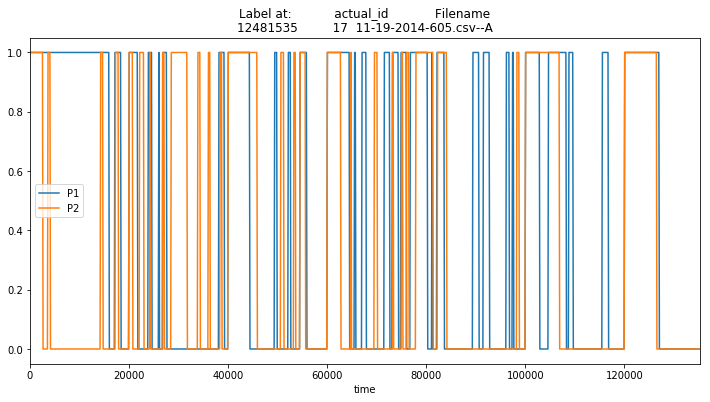

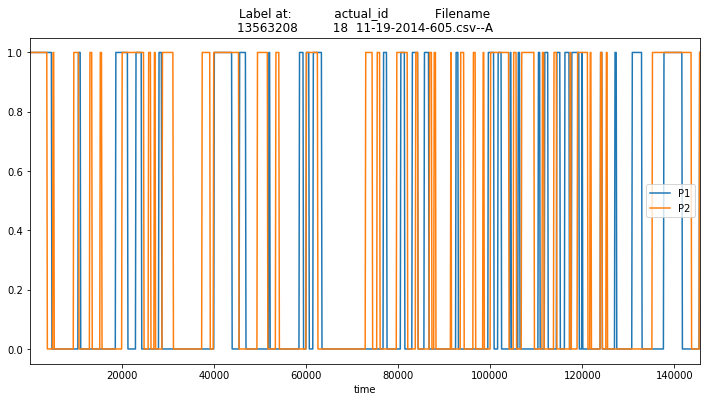

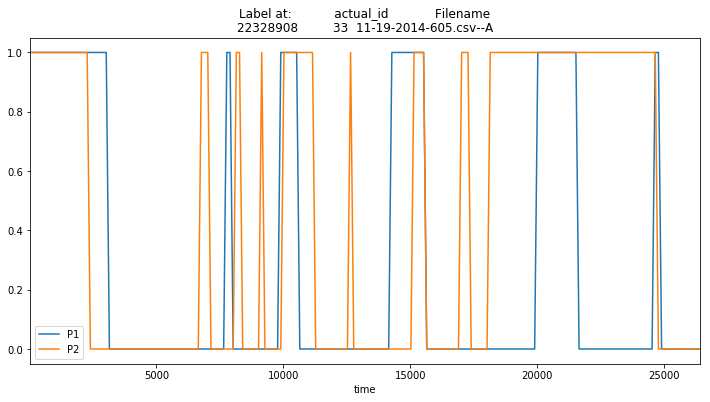

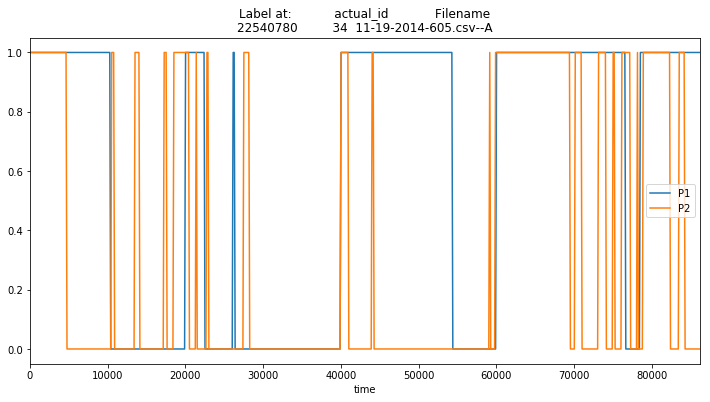

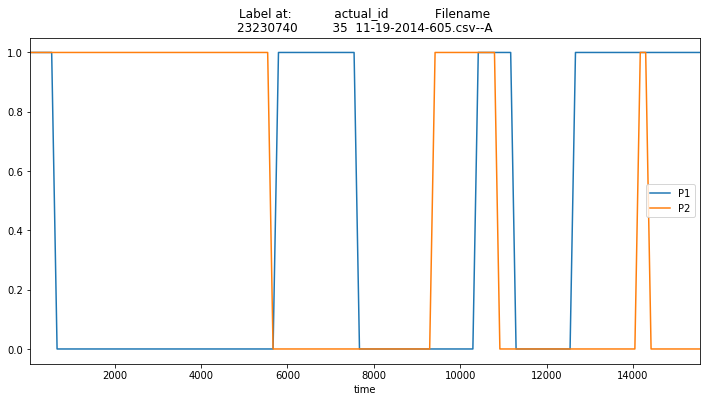

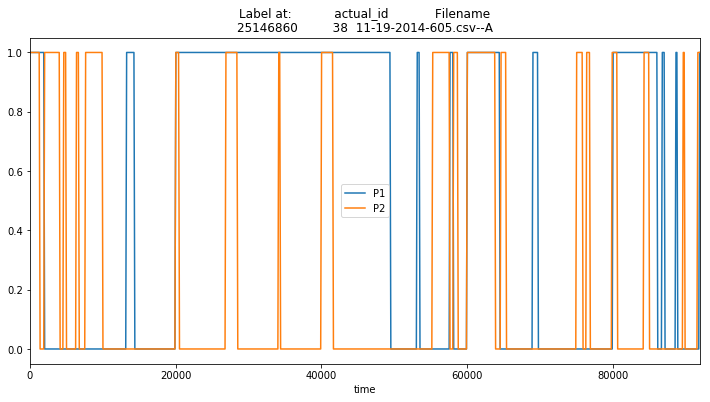

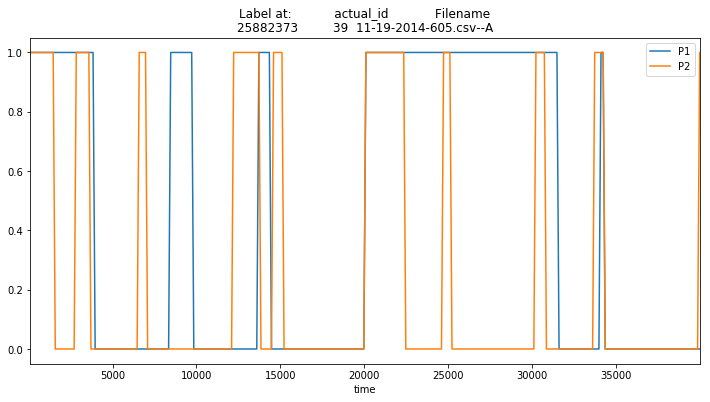

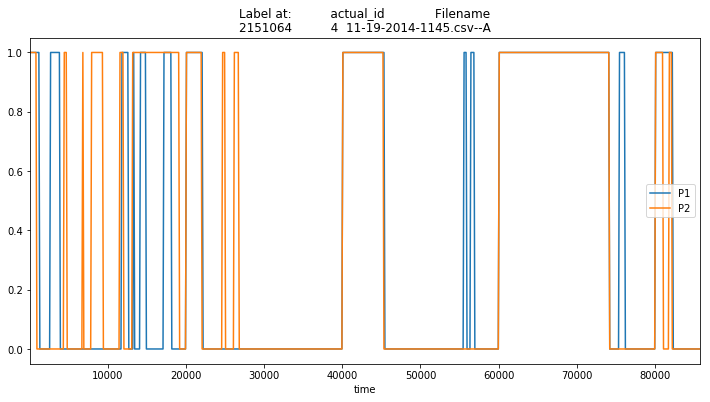

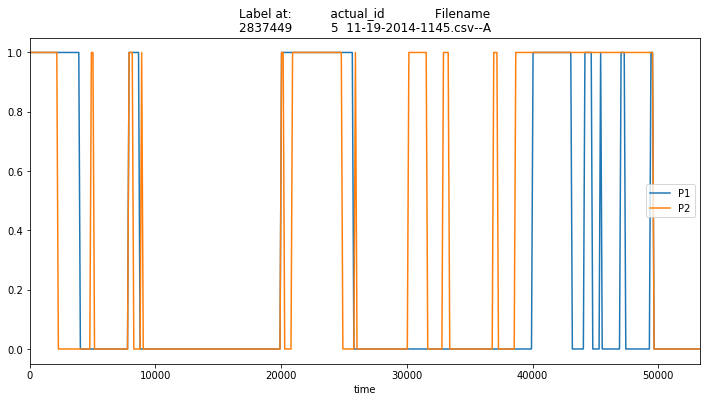

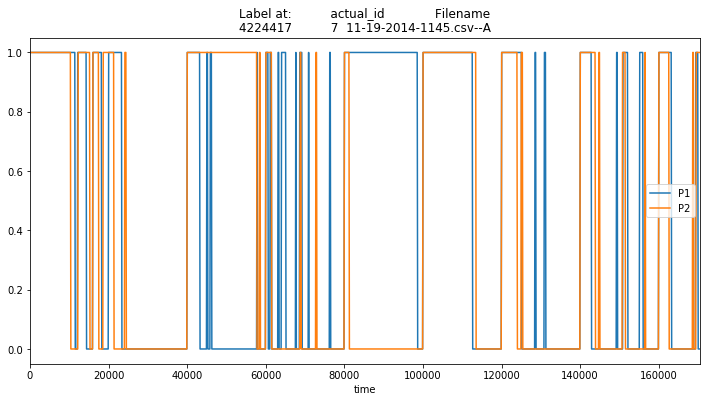

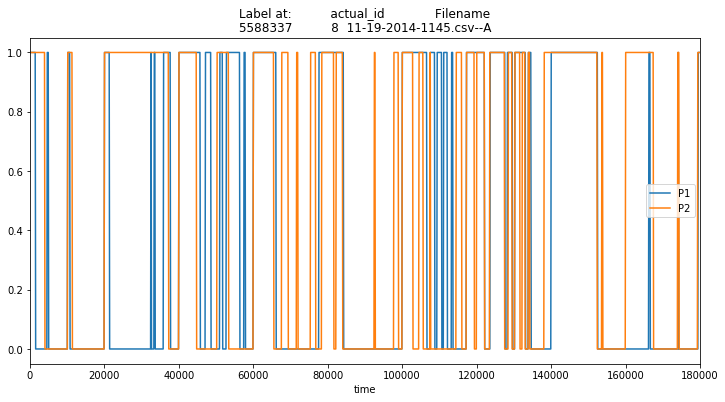

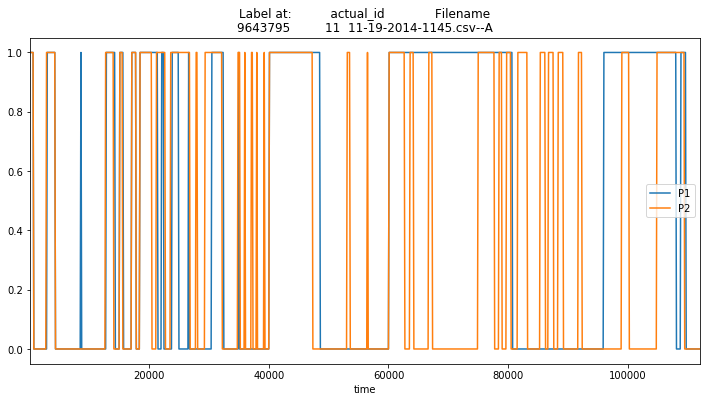

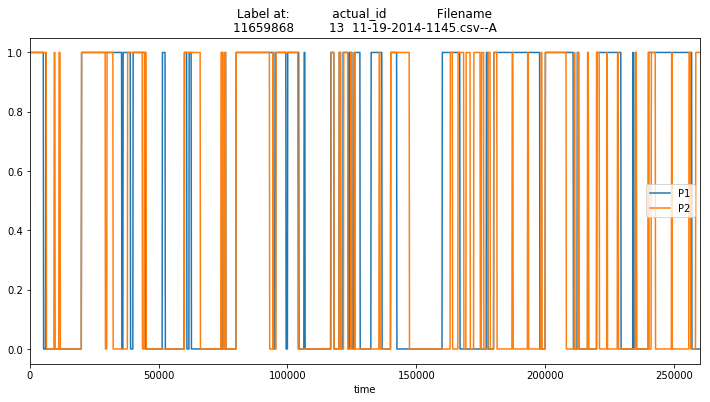

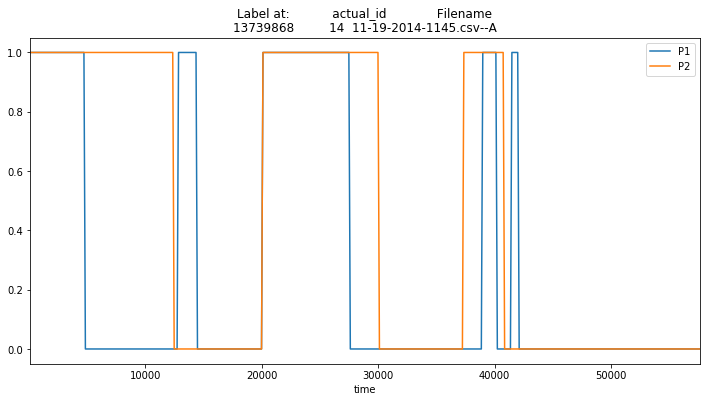

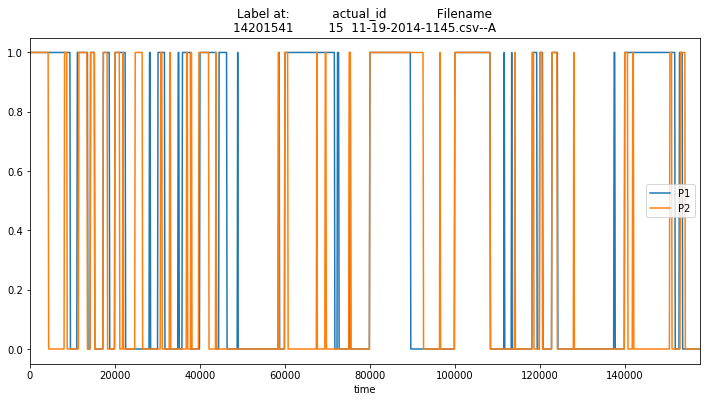

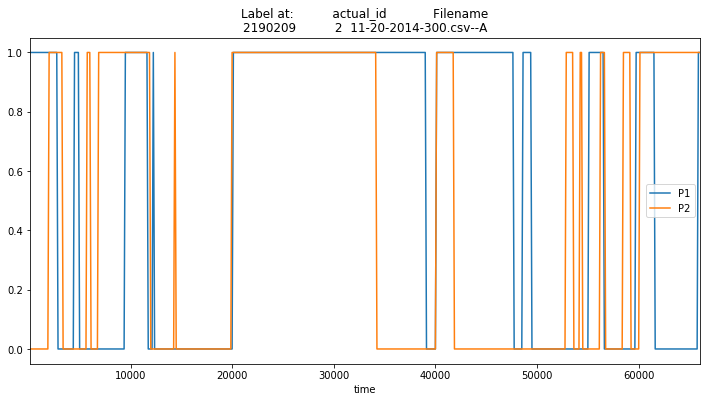

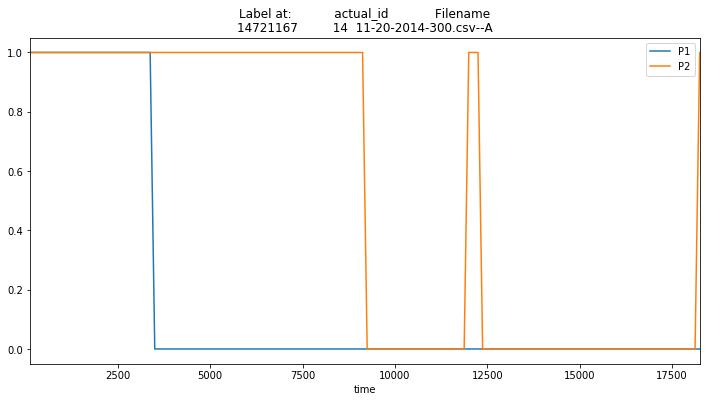

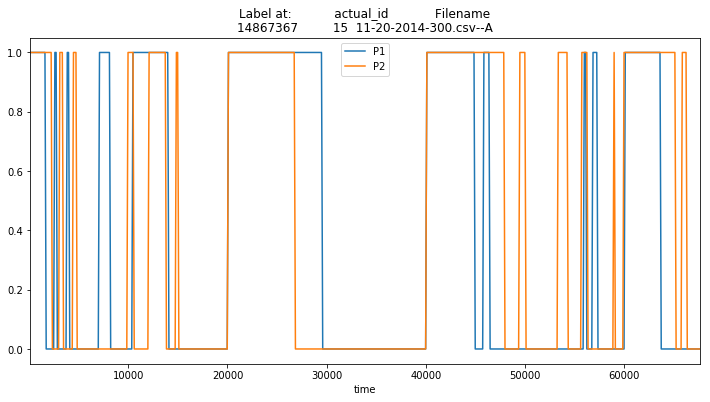

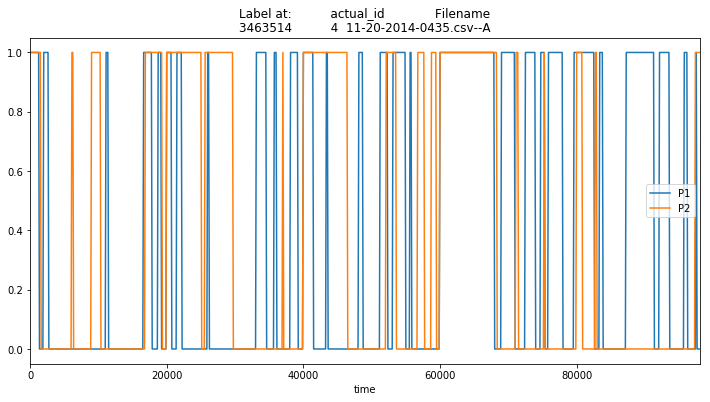

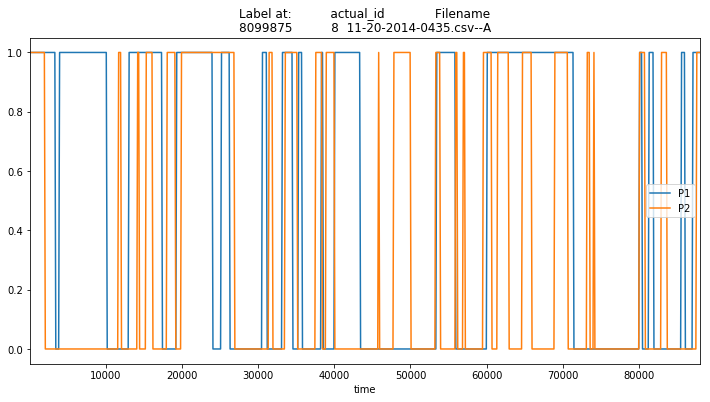

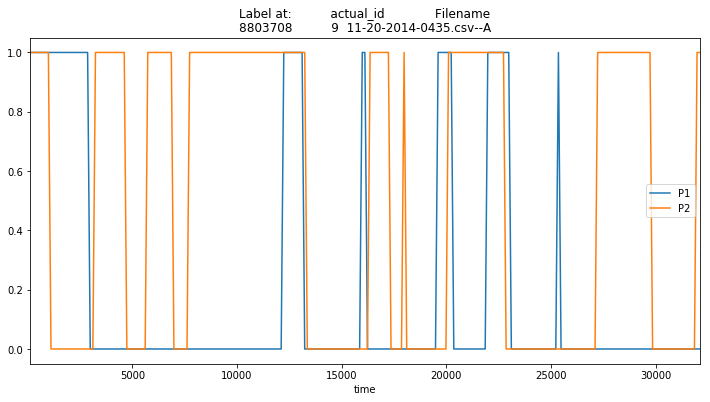

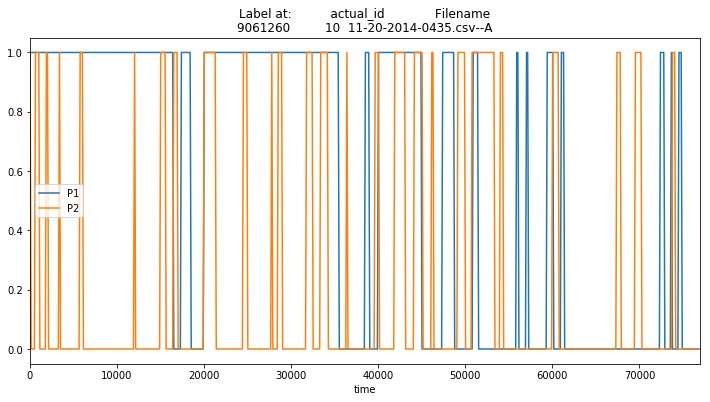

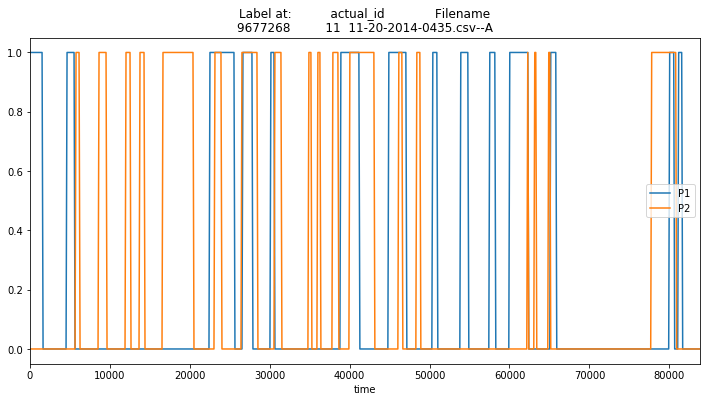

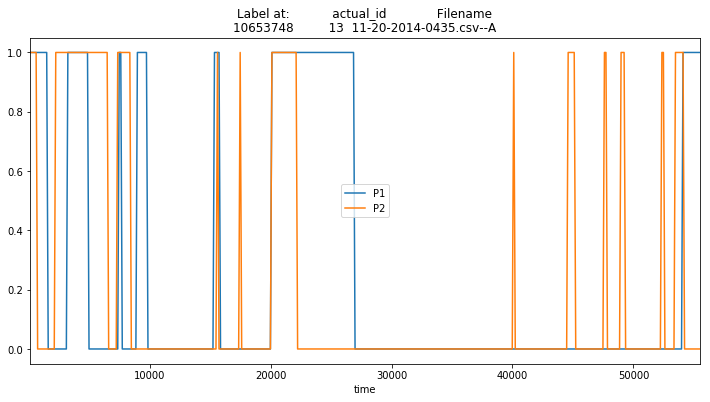

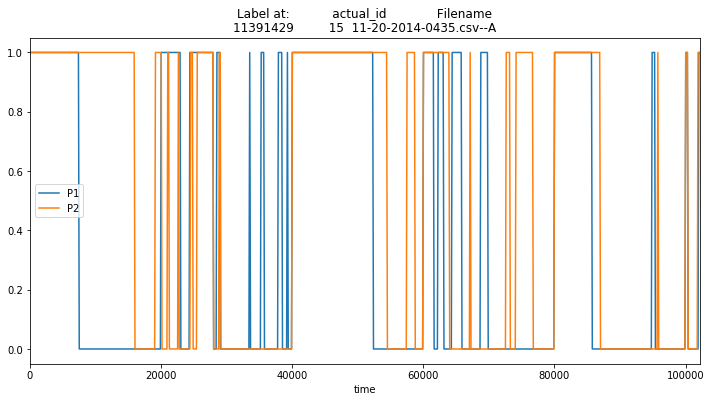

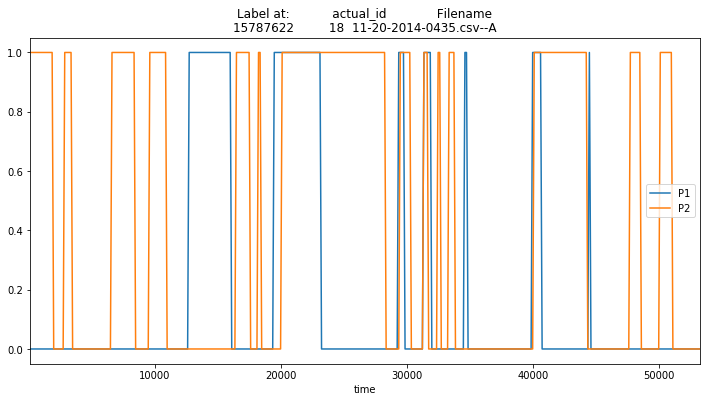

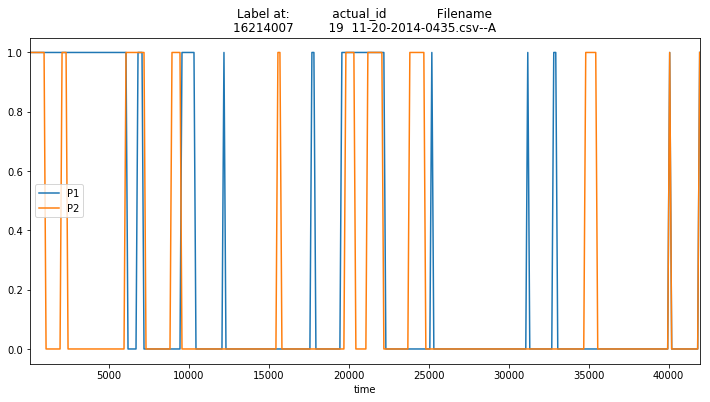

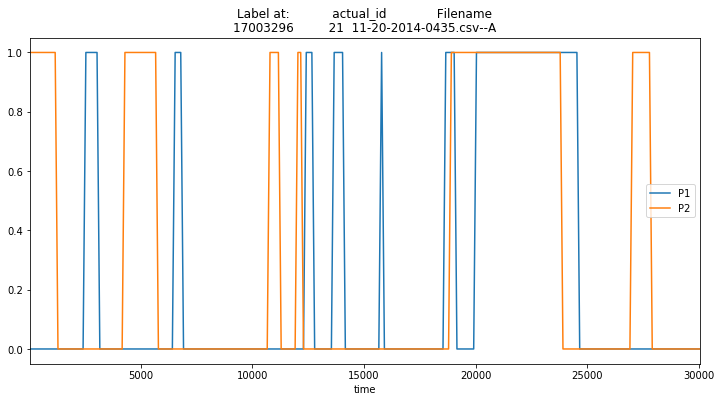

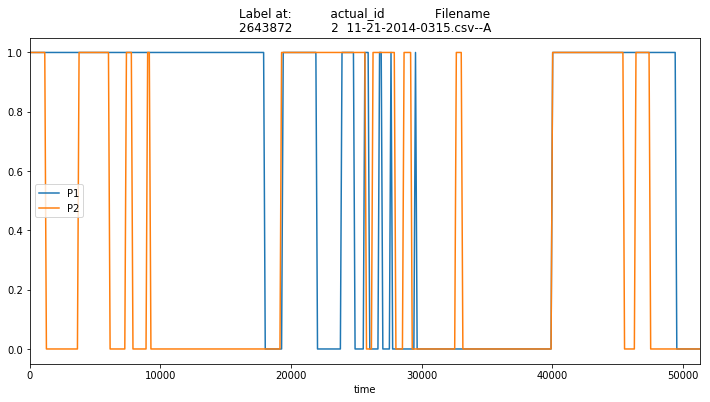

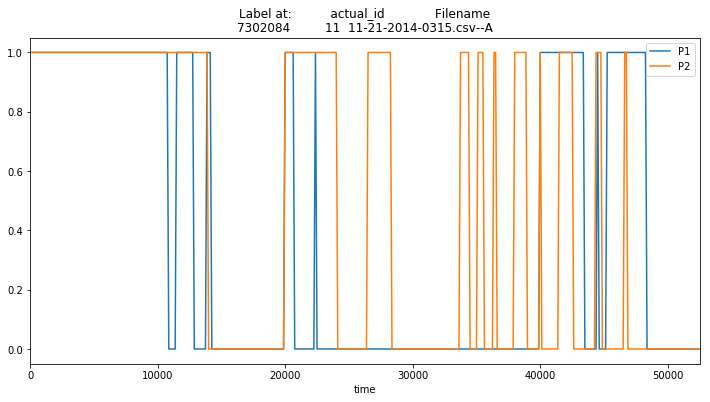

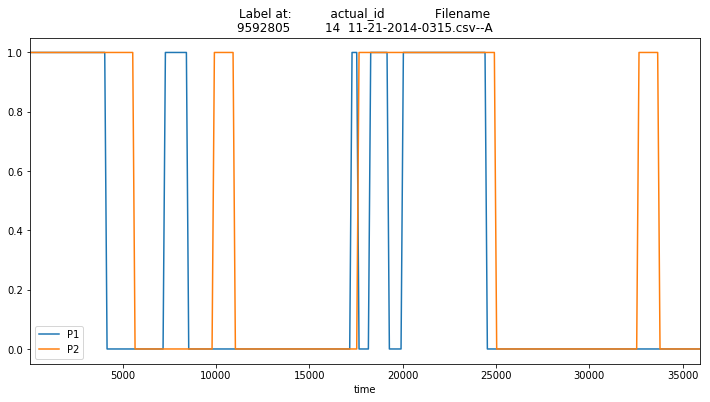

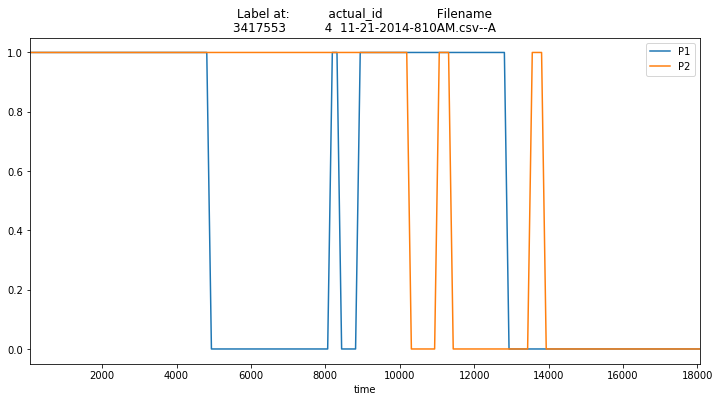

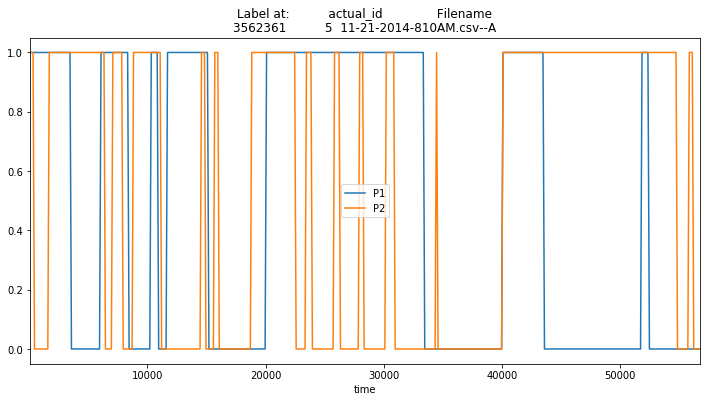

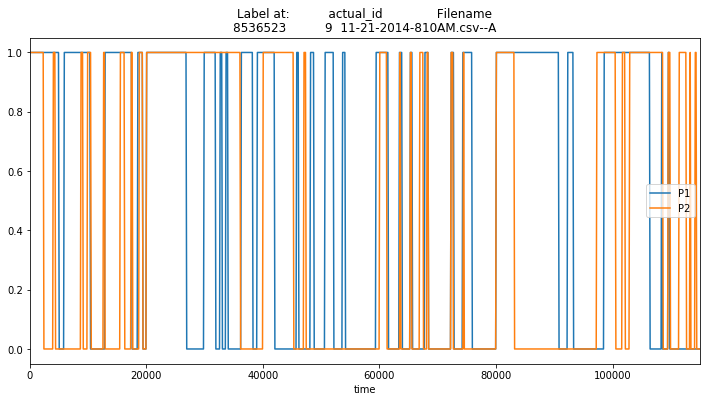

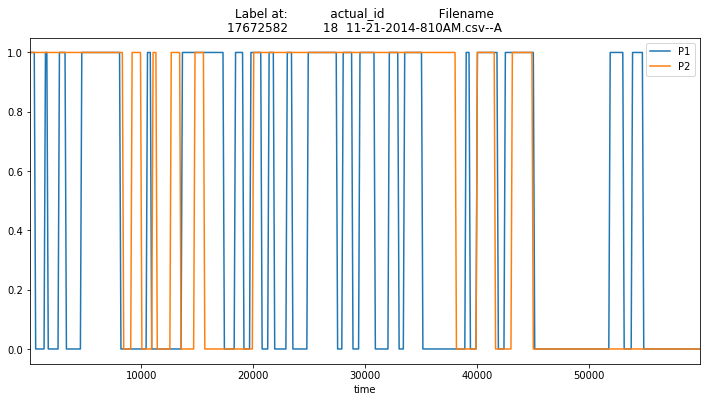

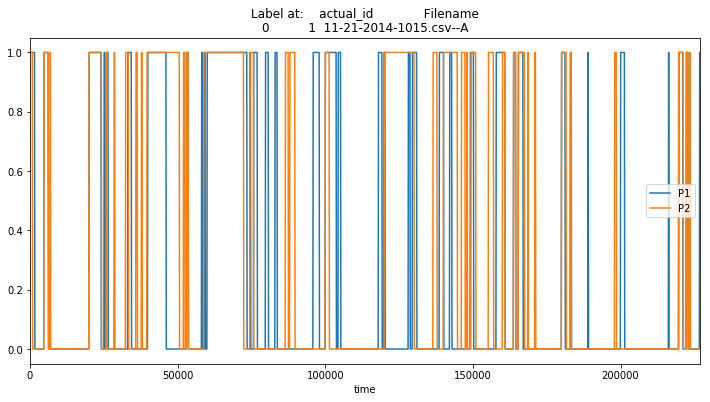

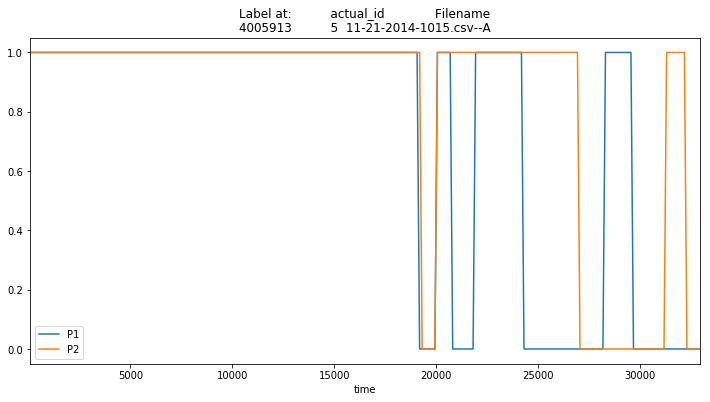

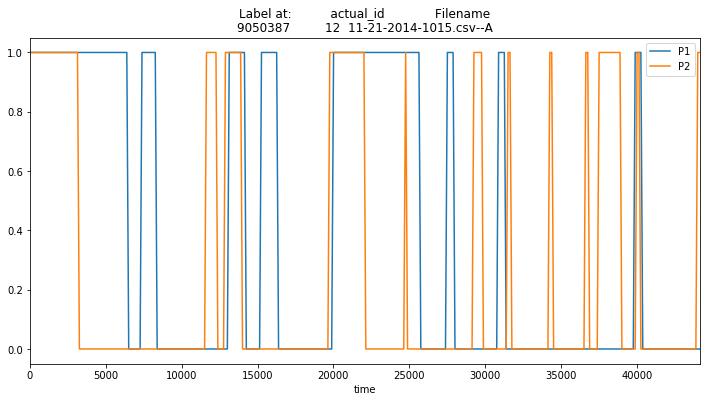

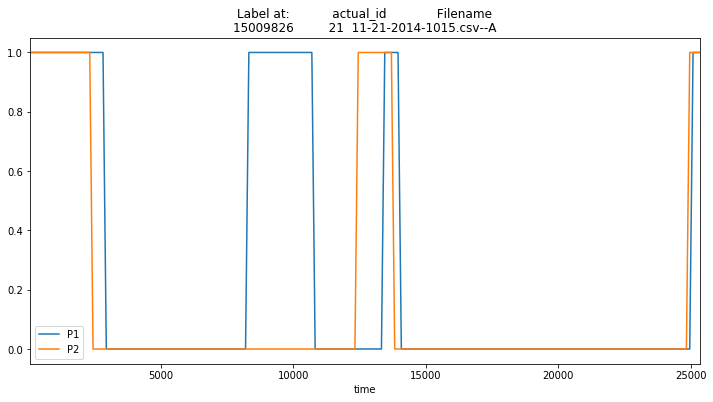

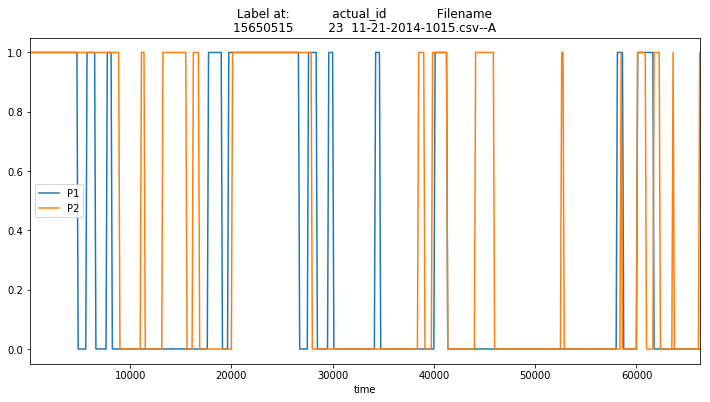

In [37]:
# Print Time series graphs
import matplotlib
pdf_doc = matplotlib.backends.backend_pdf.PdfPages('A-plots.pdf')
for i in id_values:
    if data[data.id == i].label.unique()[0] == 'A':
        sub_data_plot = data[(data['id'] == i)][['time', 'P1', 'P2']].plot(x='time', title="Label at: "+str(file_list.loc[file_list['id']==i,["actual_id","Filename"]])+
                                                      "--"+data[data.id == i].label.unique()[0], figsize=(12, 6));
        pdf_doc.savefig(sub_data_plot.get_figure())
        
pdf_doc.close()

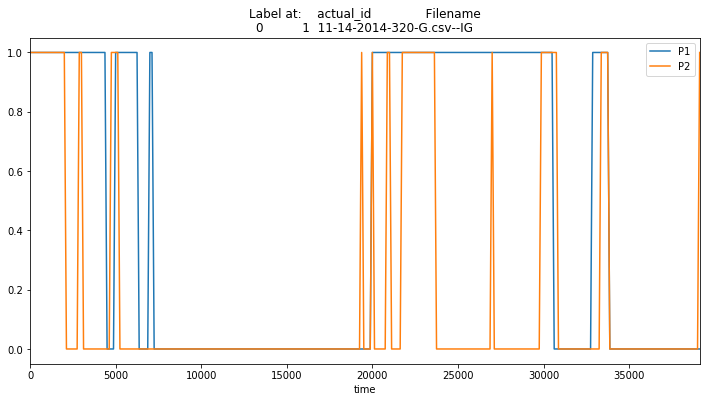

In [32]:
t = data[(data['id'] == 1)][['time', 'P1', 'P2']].plot(x='time', title="Label at: "+str(file_list.loc[file_list['id']==1,["actual_id","Filename"]])+
                                                      "--"+data[data.id == i].label.unique()[0], figsize=(12, 6));

In [33]:
t

In [ ]:
extraction_settings = ComprehensiveFCParameters()

In [ ]:
data = data[data.label != 'IG']
data_input = data[['time','P1','P2','id']]
data_input.id.unique()

In [ ]:
# Fix minor label issues with data
data.at[data.label=='C ','label'] = 'C'
data.at[data.label=='A  ','label'] = 'A'

In [ ]:
data_label = data[['label','id']]
data_label = data_label.drop_duplicates()['label']

In [ ]:
pd.Series(data_label).value_counts()

In [ ]:
data_label = data_label.as_matrix().flatten()

In [ ]:
X = extract_features(data_input, 
                     column_id='id', column_sort='time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

In [ ]:
X.info()

In [ ]:
X.shape

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
new_t = sel.fit_transform(X)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(new_t, data_label)
X_res.shape


    



In [ ]:
import pandas as pd
pd.Series(y_res).value_counts()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res_filtered, y_res, test_size=0.20, random_state=42)






forest = RandomForestClassifier(n_estimators=20)

forest.fit(X_train,y_train)
print(classification_report(y_test, forest.predict(X_test)))
confusion_matrix(y_test, forest.predict(X_test))

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_res, y_res)
model = SelectFromModel(lsvc, prefit=True)

X_new = model.transform(X_res)

In [ ]:
print(X_res.shape,y_res.shape)

In [ ]:
X_test[0]